===================================================
### Code developed by: Vinicius Luiz Santos Silva

### Contact: v.santos-silva19@imperial.ac.uk
===================================================

In [1]:
%%javascript
IPython.notebook.kernel.execute(`notebookName = '${IPython.notebook.notebook_name}'`)

<IPython.core.display.Javascript object>

In [2]:
notebookName='WGAN-GP-training_4'
notebookName

'WGAN-GP-training_4'

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
# Constants


## Load data

In [6]:
# Mesh size
nl = 10
nc = 10
print('Grid: ', nl, 'x',nc)

Grid:  10 x 10


In [7]:
import joblib
#joblib.dump(pca_compress, "pca_compress_15.pkl") 
#np.savetxt('X_train_1D.csv', X_train_1D, delimiter=',') 
#np.savetxt('X_train_pca.csv', X_train_pca, delimiter=',') 
#np.savetxt('times.csv', times, delimiter=',') 
#with open('groups.txt','w') as f:
#    f.writelines([g + '\n' for g in groups])

#...
pca_compress = joblib.load("/content/drive/MyDrive/masters/small_dataset/pca_compress_15.pkl") 
X_train_compressed = np.loadtxt('/content/drive/MyDrive/masters/small_dataset/X_train_pca.csv', delimiter=',') 

X_train_1D = np.loadtxt('/content/drive/MyDrive/masters/small_dataset/X_train_1D.csv', delimiter=',') 
times  = np.loadtxt('/content/drive/MyDrive/masters/small_dataset/times.csv', delimiter=',') 
with open('/content/drive/MyDrive/masters/small_dataset/groups.txt') as f:
    groups = [g.strip() for g in f.readlines()]

# PCA recovered
X_recovered = pca_compress.inverse_transform(X_train_compressed)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


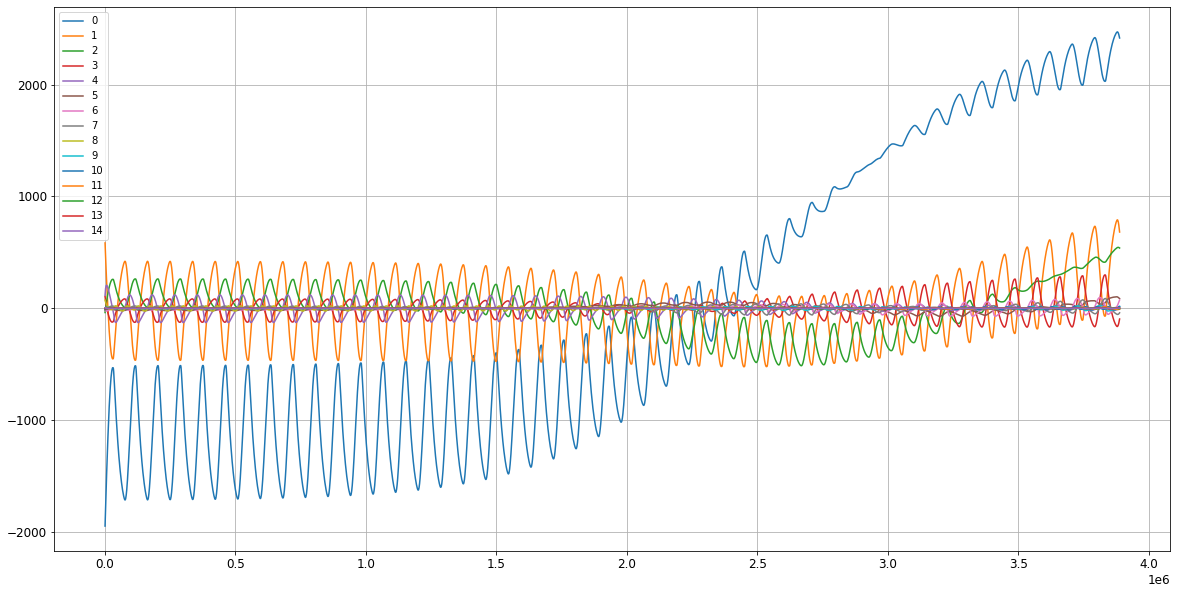

In [8]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(times, X_train_compressed);
ax.grid()
ax.legend(range(15))

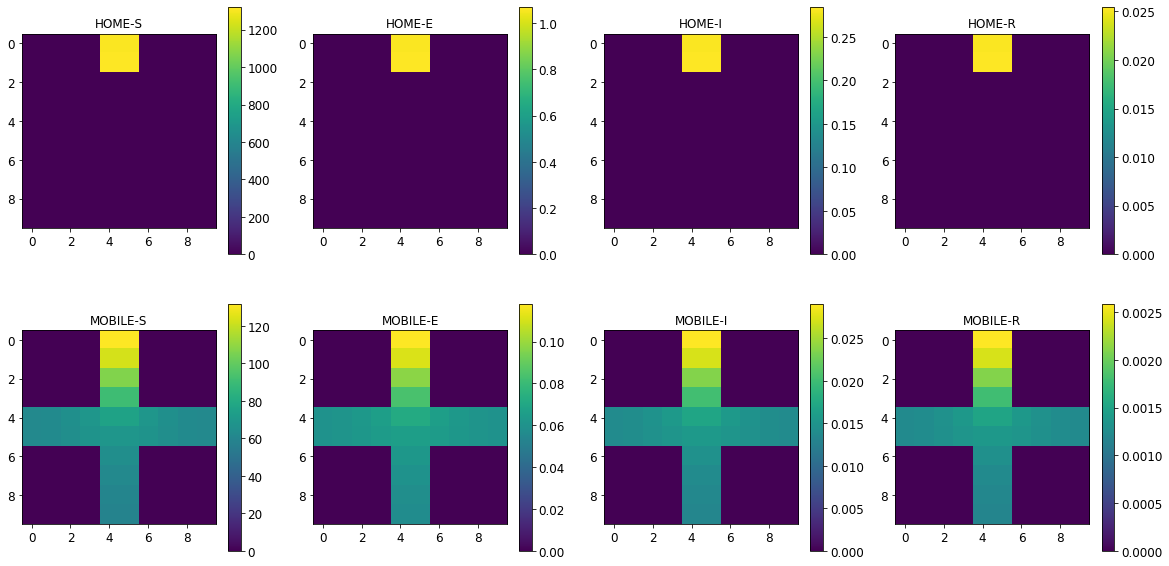

In [9]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_train_1D.reshape(len(times),len(groups),nl,nc)[100,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

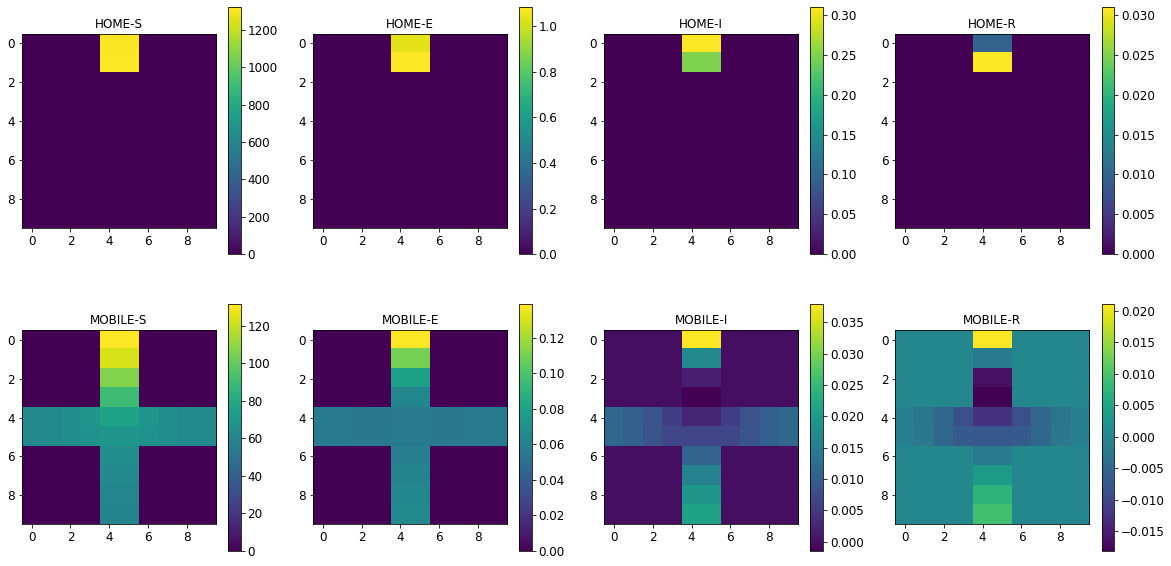

In [10]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_recovered.reshape(len(times),len(groups),nl,nc)[100,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

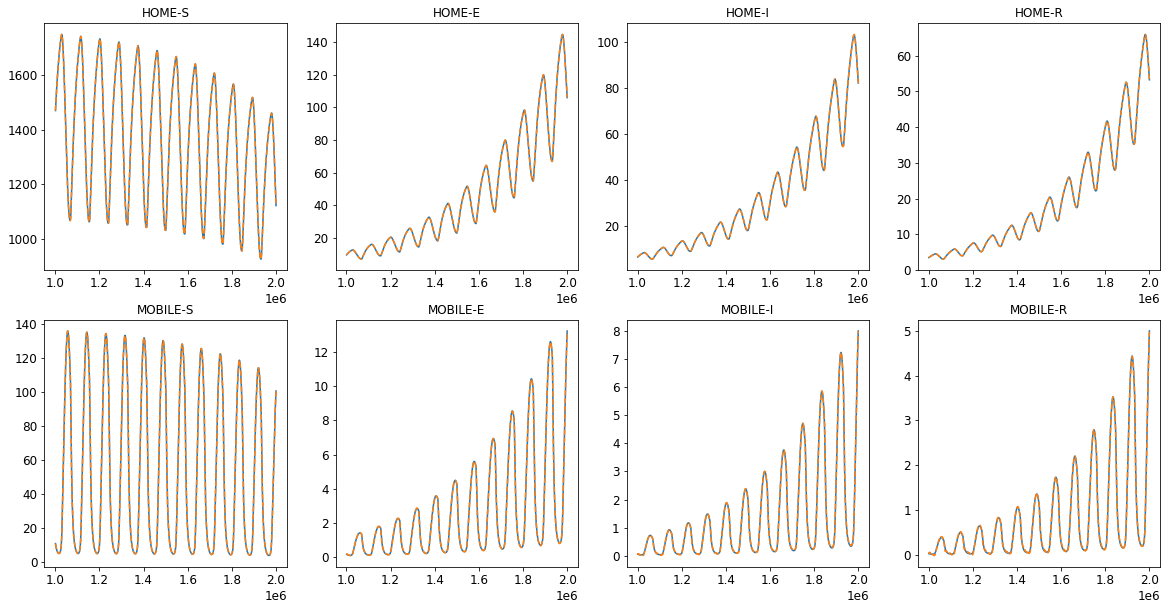

In [11]:


fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times[1000:2000], X_train_1D[1000:2000,i*nl*nc+4])
    ax.flatten()[i].plot(times[1000:2000], X_recovered[1000:2000,i*nl*nc+4],'--')
    ax.flatten()[i].set_title(group)

## Prepare data

In [12]:
codings_size = X_train_compressed.shape[1]
X_train_compressed.shape

(3888, 15)

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_compressed)*2 -1 
np.allclose(X_train_compressed, scaler.inverse_transform((X_train_scaled+1)/2))

True

In [14]:
def concat_timesteps(X_train, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train) - ntimes*step):
        X_train_concat.append(X_train[i:i+ntimes*step:step])
    return np.array(X_train_concat)

In [15]:
ntimes = 9 # Consecutive times for the GAN
step = 10 # step between times

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)
print(X_train_concat.shape[0])
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes )

3798


(3798, 9, 15)


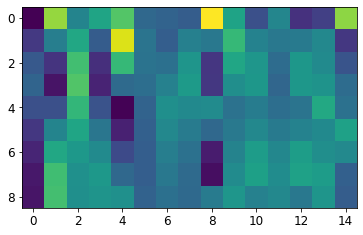

In [16]:
print(X_train_concat.shape)
plt.imshow(X_train_concat[0, :, :])

## Train the GAN

In [17]:
BATCH_SIZE = 256
latent_space = 100

# Create a tensorflow dataset and split it into batches
print(np.shape(X_train_concat))
train_dataset = X_train_concat.reshape(X_train_concat.shape[0], 9, 15, 1).astype('float32')
print(np.shape(train_dataset))
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
print(len(X_train_concat))
train_dataset = train_dataset.shuffle(len(X_train_concat))
train_dataset = train_dataset.batch(BATCH_SIZE)
print(type(train_dataset))
for data in train_dataset:
    print(data)
    break

(3798, 9, 15)
(3798, 9, 15, 1)
3798
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
tf.Tensor(
[[[[-0.8714573 ]
   [ 0.41269067]
   [-0.03803205]
   ...
   [ 0.02790683]
   [ 0.15546417]
   [-0.52482396]]

  [[-0.8238318 ]
   [ 0.28626817]
   [ 0.01074563]
   ...
   [-0.24324366]
   [-0.08109552]
   [-0.25538453]]

  [[-0.63869643]
   [-0.17896375]
   [ 0.18209937]
   ...
   [-0.12785973]
   [-0.19086379]
   [-0.21607009]]

  ...

  [[-0.6231929 ]
   [-0.1959109 ]
   [ 0.17639028]
   ...
   [-0.15947321]
   [-0.09182207]
   [ 0.12848313]]

  [[-0.7515072 ]
   [ 0.12481044]
   [ 0.05791133]
   ...
   [ 0.03135829]
   [-0.07394532]
   [-0.00534387]]

  [[-0.83443916]
   [ 0.3316901 ]
   [-0.0184795 ]
   ...
   [ 0.11308888]
   [ 0.04923287]
   [-0.30253562]]]


 [[[ 0.17945325]
   [-0.25083846]
   [-0.8618377 ]
   ...
   [-0.4661242 ]
   [-0.21196976]
   [-0.20579672]]

  [[ 0.17215312]
   [-0.10547156]
   [-0.9673872 ]
   ...
   [-0.7866296 ]
   [ 0.03419476]
   [-0.261781

In [18]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(5*4*256, use_bias=False, input_shape=(latent_space,)))
    #model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Reshape((5, 4, 256)))

    model.add(keras.layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    #model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(64, (3, 3), strides=(1, 2), padding='same', use_bias=False))
    #model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', output_padding=[0,0], use_bias=False, activation='tanh'))

    return model

In [19]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5120)              512000    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5120)              0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 4, 128)         294912    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 5, 8, 64)          73728     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 5, 8, 64)          0

(1, 9, 15, 1)


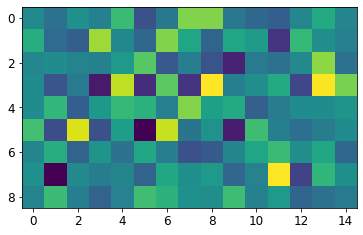

In [20]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0])

In [21]:
def make_critic_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[9, 15, 1]))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(128, (5, 5), strides=(1, 2), padding='same'))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))
    # could swap dropout and flatten layers
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))

    return model

In [22]:
critic = make_critic_model()
critic.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5, 8, 64)          640       
_________________________________________________________________
layer_normalization (LayerNo (None, 5, 8, 64)          128       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 5, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 8, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 4, 128)         204928    
_________________________________________________________________
layer_normalization_1 (Layer (None, 5, 4, 128)         256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 5, 4, 128)        

In [23]:
decision = critic(generated_image)
print (decision)

tf.Tensor([[-0.5342795]], shape=(1, 1), dtype=float32)


In [24]:
#gan = keras.models.Sequential([generator, discriminator])
wgan = keras.models.Sequential([generator, critic])

In [25]:
# This method returns a helper function to compute cross entropy loss
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# def discriminator_loss(real_output, fake_output):
#     real_loss = cross_entropy(tf.ones_like(real_output), real_output)
#     fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
#     total_loss = real_loss + fake_loss
#     return total_loss

def critic_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    return fake_loss - real_loss


# def generator_loss(fake_output):
#     return cross_entropy(tf.ones_like(fake_output), fake_output)

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
critic_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

In [26]:
# The discriminator and the generator optimizers are different since we will train two networks separately.
# generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
critic_optimizer = tf.keras.optimizers.Adam(1e-4)
# generator_optimizer = keras.optimizers.Adam(
#     learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
# critic_optimizer = keras.optimizers.Adam(
#     learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

In [27]:
def gradient_penalty(real, fake):
    """
    WGAN-GP uses gradient penalty instead of the weight
    clipping to enforce the Lipschitz constraint.
    """

    # alpha = tf.random.normal([self.BATCH_SIZE, self.n_var], mean=0.0, stddev=0.1)
    if real.shape[0]==BATCH_SIZE:
        alpha = tf.random.uniform(shape=[BATCH_SIZE, 1, 1, 1], minval=0., maxval=1.)
    else:
        alpha = tf.random.uniform(shape=[real.shape[0]%BATCH_SIZE, 1, 1, 1], minval=0., maxval=1.)
    interpolated = real + alpha * (fake - real)
    # print('interpolated ', np.shape(interpolated))

    with tf.GradientTape() as t:
        t.watch(interpolated)
        pred = critic(interpolated, training=True)
        # print('pred', np.shape(pred))
    grad = t.gradient(pred, interpolated)
    gradient_norm = tf.norm(grad)
    gp = tf.reduce_mean((gradient_norm - 1)**2)
    return gp
    # print('grad', np.shape(grad))
    # print('tf.square(grad)', tf.shape(tf.square(grad)))
    # print('tf.reduce_sum(tf.square(grad)', tf.shape(tf.reduce_sum(tf.square(grad))))
    # print('tf.sqrt(tf.reduce_sum(tf.square(grad)) + 1e-12)', tf.shape(tf.sqrt(tf.reduce_sum(tf.square(grad)) + 1e-12)))
    # norm = tf.sqrt(tf.reduce_sum(tf.square(grad)) + 1e-12)
    # print('norm', tf.shape(norm))


In [28]:
# We will reuse this seed overtime 
num_examples_to_generate = 5
seed = tf.random.normal([num_examples_to_generate, latent_space])

In [29]:
# logs to follow losses on tensorboard
#current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
generator_log_dir = './logs/' + 'WGAN-GP_4' + '/generator'
critic_log_dir = './logs/' + 'WGAN-GP_4' + '/critic'

generator_summary_writer = tf.summary.create_file_writer(generator_log_dir)
critic_summary_writer = tf.summary.create_file_writer(critic_log_dir)

In [30]:
@tf.function
def train_G(batch):
    """
    The training routine for the generator
    """
    if batch.shape[0]==BATCH_SIZE:
        noise = tf.random.normal([BATCH_SIZE, latent_space], mean=0.0, stddev=0.1)
    else:
        noise = tf.random.normal([batch.shape[0]%BATCH_SIZE, latent_space], mean=0.0, stddev=0.1)

    with tf.GradientTape() as gen_tape:
        generated_data = generator(noise, training=True)
        fake_output = critic(generated_data, training=True)
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    # return tf.math.abs(gen_loss)
    # print('gen_loss', tf.shape(gen_loss))
    return gen_loss

In [31]:

@tf.function
def train_D(batch):
    """
    The training routine for the critic
    """
    if batch.shape[0]==BATCH_SIZE:
        noise = tf.random.normal([BATCH_SIZE, latent_space], mean=0.0, stddev=0.1)
    else:
        noise = tf.random.normal([batch.shape[0]%BATCH_SIZE, latent_space], mean=0.0, stddev=0.1)

    with tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)

        real_output = critic(batch, training=True)
        fake_output = critic(generated_data, training=True)

        disc_loss = critic_loss(real_output, fake_output)
        gp = gradient_penalty(batch, generated_data)
        # disc_loss += (self.critic_loss(real_output, fake_output) + gp*10.0)
        disc_loss += gp*10.0

    gradients_of_critic = disc_tape.gradient(disc_loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))

    # return tf.math.abs(disc_loss)
    # print('disc_loss', tf.shape(disc_loss))
    # print('disc_slice', tf.slice(disc_loss, [0], [-1]))
    

    return disc_loss

In [32]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# @tf.function
# def train_step(batch):
#     noise = tf.random.normal([BATCH_SIZE, latent_space])

#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#         generated_images = generator(noise, training=True)

#         real_output = discriminator(batch, training=True)
#         fake_output = discriminator(generated_images, training=True)

#         gen_loss = generator_loss(fake_output)
#         disc_loss = discriminator_loss(real_output, fake_output)

#     gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
#     gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#     generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#     discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
#     generator_mean_loss(gen_loss)
#     discriminator_mean_loss(disc_loss)


In [33]:
# test_count = 0
# def test_f(test_count):
#   print('done')
#   test_count += 1
#   return test_count

# def train_test(test_count, epochs=10):
#   for epoch in range(epochs):
#     test_f(test_count)
#     test_count = test_f(test_count)
#     print(test_count)
    
#   return 1

# bla = train_test(test_count)




In [34]:
# def train(dataset, epochs, scaler, scaled, X_train, y_train,n_critic=5):
def train(dataset, epochs, n_critic=5):
    """
    Training the WGAN-GP
    """

    hist = []
    for epoch in range(epochs):
        start = time.time()
        print("Epoch {}/{}".format(epoch, epochs))

        for batch in dataset:

            for _ in range(n_critic):
              # train_D(batch, count_D)
              disc_loss = train_D(batch)
            critic_mean_loss(disc_loss)
            # print('critic_mean_loss', critic_mean_loss.numpy())

            


            gen_loss = train_G(batch)
            generator_mean_loss(gen_loss)
            # train_G(batch, count_G)

        with critic_summary_writer.as_default():
              tf.summary.scalar('loss', critic_mean_loss.result(), step=epoch)

        with generator_summary_writer.as_default():
            tf.summary.scalar('loss', generator_mean_loss.result(), step=epoch)

        # with critic_summary_writer.as_default():
        #     tf.summary.scalar('loss', critic_mean_loss.result(), step=epoch)

        hist.append([generator_mean_loss.result().numpy(), critic_mean_loss.result().numpy()])

        generator_mean_loss.reset_states()
        critic_mean_loss.reset_states()

        # print("critic", "{}: {:.6f}".format(critic.metrics_names[0], hist[-1][1]), end=' - ')
        # print("generator", "{}: {:.6f}".format(wgan.metrics_names[0], hist[-1][0]), end=' - ')    
        # print ('{:.0f}s'.format( time.time()-start))

        print("critic: {:.6f}".format(hist[-1][1]), end=' - ')
        print("generator: {:.6f}".format(hist[-1][0]), end=' - ')
        print('{:.0f}s'.format( time.time()-start))

        print('disc_numpy', disc_loss.numpy())
        print('gen_numpy', gen_loss.numpy())
        # Global variables are used below
        if epoch%1000 == 0: 
            # Plot generated data
            X_generated = scaler.inverse_transform((generator.predict(seed).reshape(num_examples_to_generate*ntimes,15)+1)/2)
            X_generated = pca_compress.inverse_transform(X_generated)
            X_generated = X_generated.reshape(num_examples_to_generate, ntimes, len(groups)*nl*nc)
            fig, ax = plt.subplots(num_examples_to_generate*2,len(groups), figsize=[20,num_examples_to_generate*5])
            for j in range(num_examples_to_generate):
                for i, group in enumerate(groups):
                    for k in range(0,10,10): 
                        ax.flatten()[i+2*j*len(groups)].plot(X_generated[j][:,i*nl*nc+4+10*k], '-')
                for i, group in enumerate(groups):
                    im = ax.flatten()[i+(2*j+1)*len(groups)].imshow(X_generated[j].reshape(ntimes,len(groups),nl,nc)[4,i,:,:])
                    fig.colorbar(im, ax=ax.flatten()[i+(2*j+1)*len(groups)])
            plt.savefig('snapshot_images/town/'+'WGAN-GP_5_'+str(epoch)+'.jpeg')
            plt.show() 
            

            # Save model
            wgan.save('ganmodels/'+'WGAN-GP_5_'+str(epoch)+'.h5')
                        
    

            # plot loss
            print('Loss: ')
            fig, ax = plt.subplots(1,1, figsize=[20,10])
            ax.plot(hist[100:])
            ax.legend(['loss_gen', 'loss_disc'])
            # ax.set_yscale('log')
            ax.grid()
            plt.savefig('snapshot_images/loss/'+'WGAN-GP_5_'+str(epoch)+'.jpeg')
            plt.show()

    return hist


In [35]:
# def train(dataset, epochs):
#     hist = []
#     for epoch in range(epochs):
#         start = time.time()
#         print("Epoch {}/{}".format(epoch + 1, epochs))   

#         for batch in dataset:
#             train_step(batch)
            
#         with generator_summary_writer.as_default():
#             tf.summary.scalar('loss', generator_mean_loss.result(), step=epoch)

#         with discriminator_summary_writer.as_default():
#             tf.summary.scalar('loss', discriminator_mean_loss.result(), step=epoch)
        
#         hist.append([generator_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])

#         generator_mean_loss.reset_states()
#         discriminator_mean_loss.reset_states()
        
#         print("discriminator", "{}: {:.6f}".format(discriminator.metrics_names[0], hist[-1][1]), end=' - ')
#         print("generator", "{}: {:.6f}".format(gan.metrics_names[0], hist[-1][0]), end=' - ')    
#         print ('{:.0f}s'.format( time.time()-start))

#         # Global variables are used below
#         if epoch%1000 == 0: 
#             # Plot generated data
#             X_generated = scaler.inverse_transform((generator.predict(seed).reshape(num_examples_to_generate*ntimes,15)+1)/2)
#             X_generated = pca_compress.inverse_transform(X_generated)
#             X_generated = X_generated.reshape(num_examples_to_generate, ntimes, len(groups)*nl*nc)
#             fig, ax = plt.subplots(num_examples_to_generate*2,len(groups), figsize=[20,num_examples_to_generate*5])
#             for j in range(num_examples_to_generate):
#                 for i, group in enumerate(groups):
#                     for k in range(0,10,10): 
#                         ax.flatten()[i+2*j*len(groups)].plot(X_generated[j][:,i*nl*nc+4+10*k], '-')
#                 for i, group in enumerate(groups):
#                     im = ax.flatten()[i+(2*j+1)*len(groups)].imshow(X_generated[j].reshape(ntimes,len(groups),nl,nc)[4,i,:,:])
#                     fig.colorbar(im, ax=ax.flatten()[i+(2*j+1)*len(groups)])
#             plt.show() 
                    
#             # Save model
#             gan.save('ganmodels/'+notebookName[:-6]+str(epoch)+'.h5')    
            
#             # plot loss
#             print('Loss: ')
#             fig, ax = plt.subplots(1,1, figsize=[20,10])
#             ax.plot(hist)
#             ax.legend(['loss_gen', 'loss_disc'])
#             ax.set_yscale('log')
#             ax.grid()
#             plt.show()
            
#     return hist


Epoch 0/10000
critic: 243862.000000 - generator: 0.107301 - 6s
disc_numpy 44377.617
gen_numpy 0.20324662


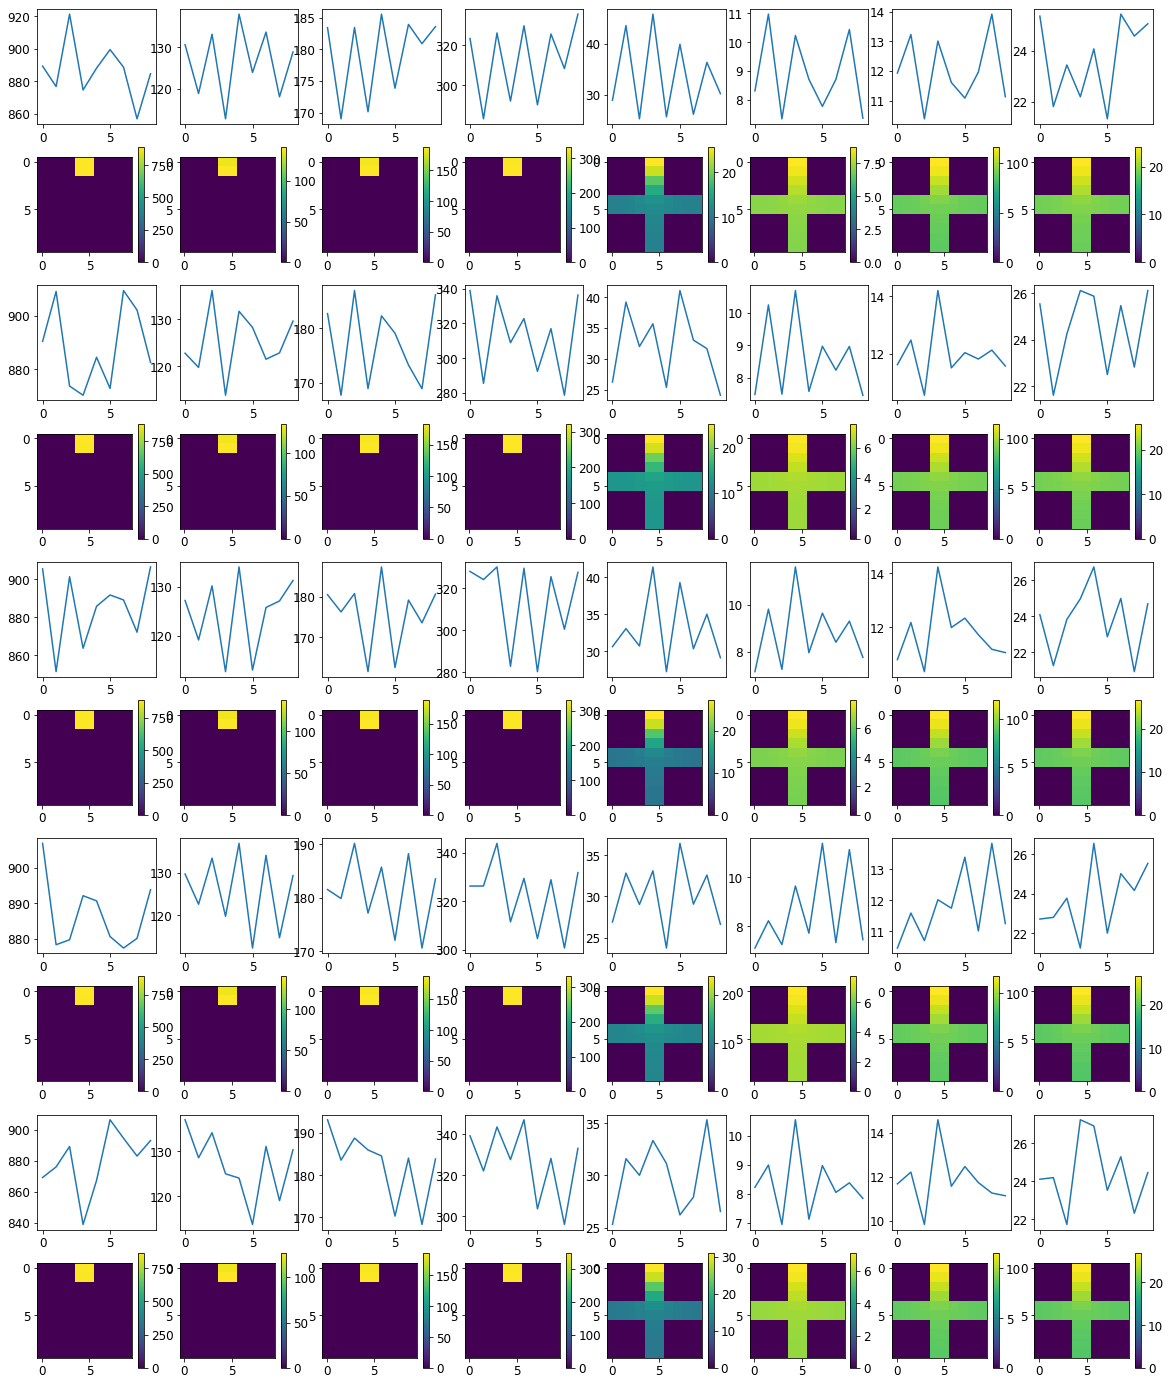

Loss: 


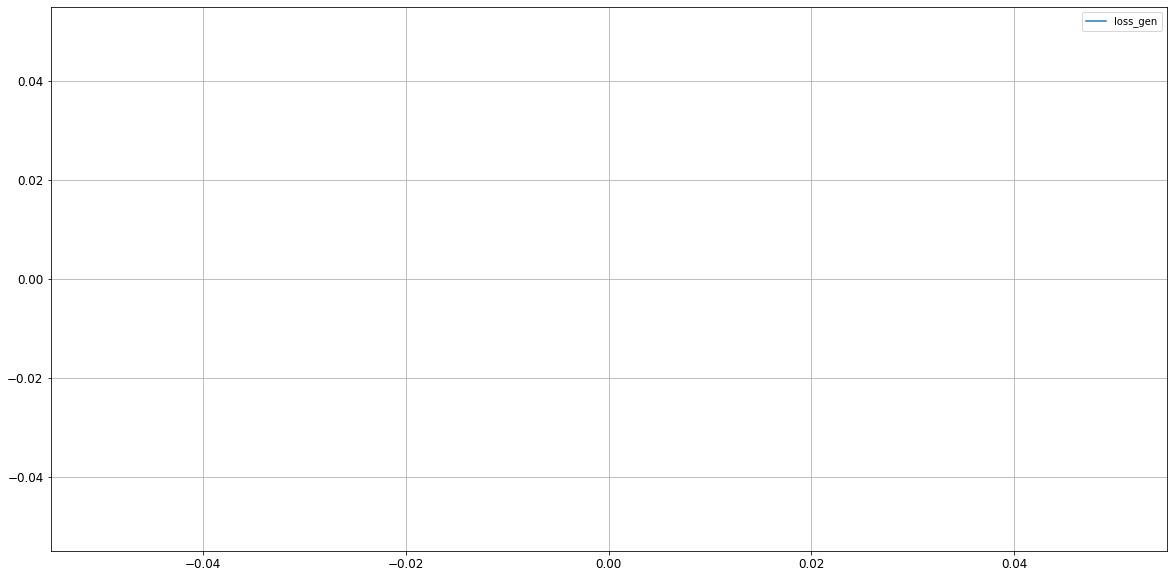

Epoch 1/10000
critic: 35874.605469 - generator: 0.172513 - 2s
disc_numpy 19208.812
gen_numpy 0.1645742
Epoch 2/10000
critic: 20248.482422 - generator: 0.192537 - 2s
disc_numpy 14650.931
gen_numpy 0.20063873
Epoch 3/10000
critic: 14492.701172 - generator: 0.199381 - 2s
disc_numpy 10589.234
gen_numpy 0.2153502
Epoch 4/10000
critic: 10977.715820 - generator: 0.207140 - 2s
disc_numpy 7977.079
gen_numpy 0.2619433
Epoch 5/10000
critic: 8187.669922 - generator: 0.204165 - 2s
disc_numpy 6178.256
gen_numpy 0.22869967
Epoch 6/10000
critic: 6534.919434 - generator: 0.195178 - 2s
disc_numpy 5180.7046
gen_numpy 0.2158959
Epoch 7/10000
critic: 5571.805176 - generator: 0.216081 - 2s
disc_numpy 4234.816
gen_numpy 0.17580552
Epoch 8/10000
critic: 5355.071777 - generator: 0.205185 - 2s
disc_numpy 4538.333
gen_numpy 0.22751698
Epoch 9/10000
critic: 5136.396484 - generator: 0.218727 - 2s
disc_numpy 3936.7517
gen_numpy 0.19035923
Epoch 10/10000
critic: 4610.468262 - generator: 0.236334 - 2s
disc_numpy 3863

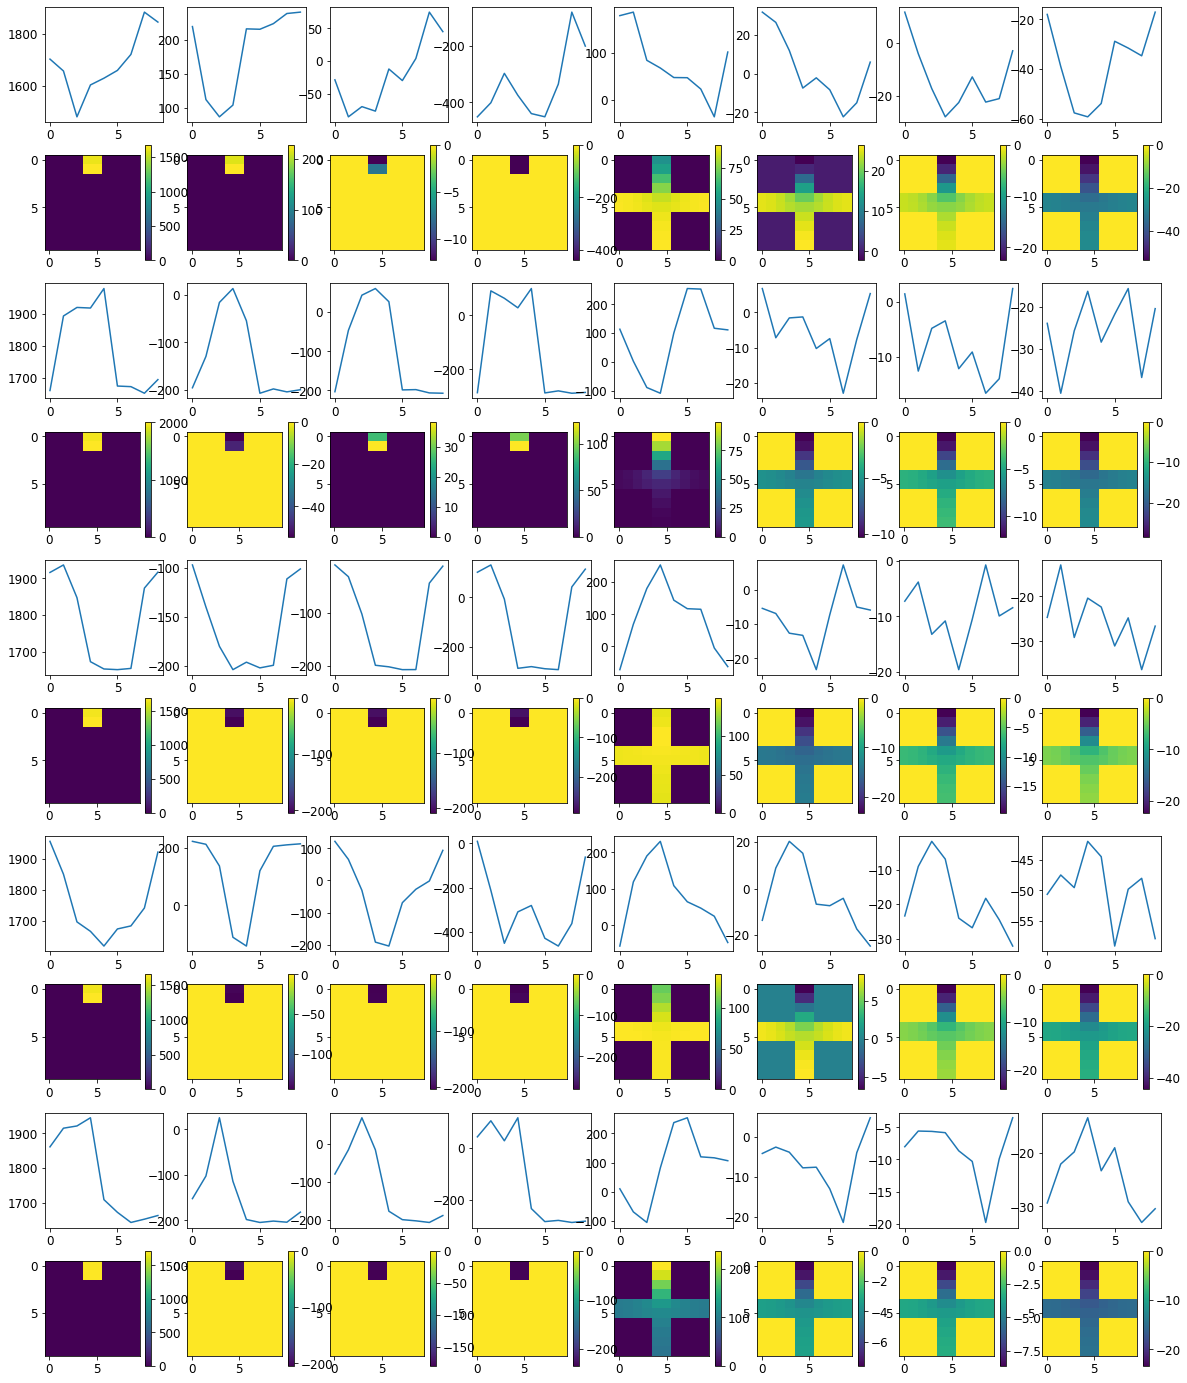

Loss: 


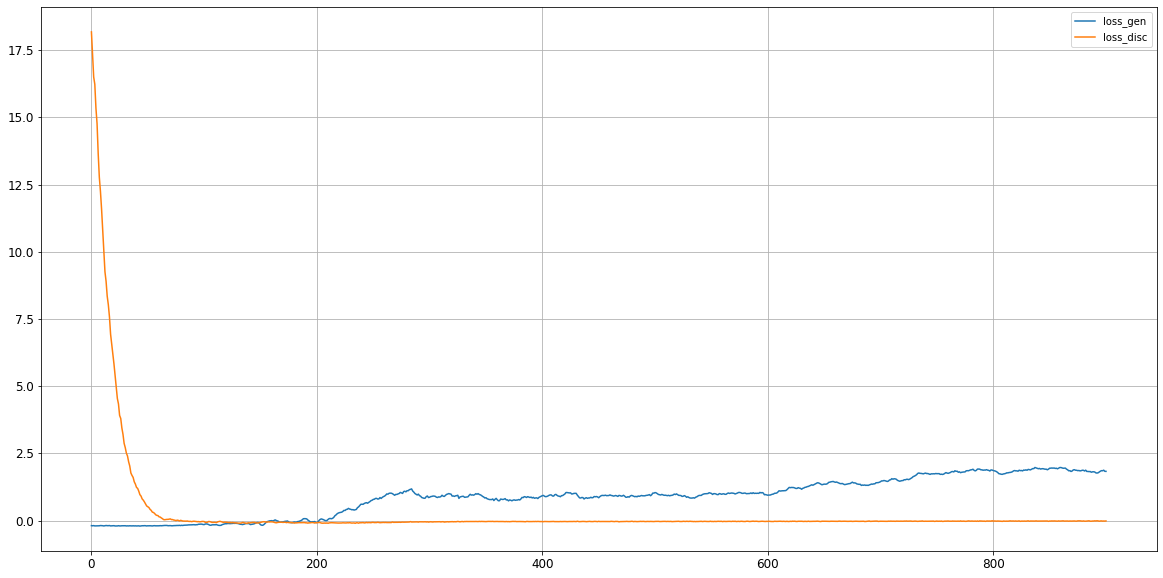

Epoch 1001/10000
critic: -0.017075 - generator: 1.796666 - 2s
disc_numpy -0.024529353
gen_numpy 1.802193
Epoch 1002/10000
critic: -0.018523 - generator: 1.828873 - 2s
disc_numpy -0.01024545
gen_numpy 1.8224216
Epoch 1003/10000
critic: -0.011935 - generator: 1.799560 - 2s
disc_numpy -0.011092933
gen_numpy 1.7616509
Epoch 1004/10000
critic: -0.021724 - generator: 1.819350 - 2s
disc_numpy 0.0060408823
gen_numpy 1.8207964
Epoch 1005/10000
critic: -0.012964 - generator: 1.809868 - 2s
disc_numpy 0.021422286
gen_numpy 1.8168036
Epoch 1006/10000
critic: -0.025525 - generator: 1.848262 - 2s
disc_numpy 0.00971492
gen_numpy 1.814686
Epoch 1007/10000
critic: -0.012265 - generator: 1.836323 - 2s
disc_numpy 0.004422603
gen_numpy 1.8194056
Epoch 1008/10000
critic: -0.016687 - generator: 1.842007 - 2s
disc_numpy -0.02047594
gen_numpy 1.8684287
Epoch 1009/10000
critic: -0.009588 - generator: 1.818783 - 2s
disc_numpy 0.015188586
gen_numpy 1.8031886
Epoch 1010/10000
critic: -0.014059 - generator: 1.84805

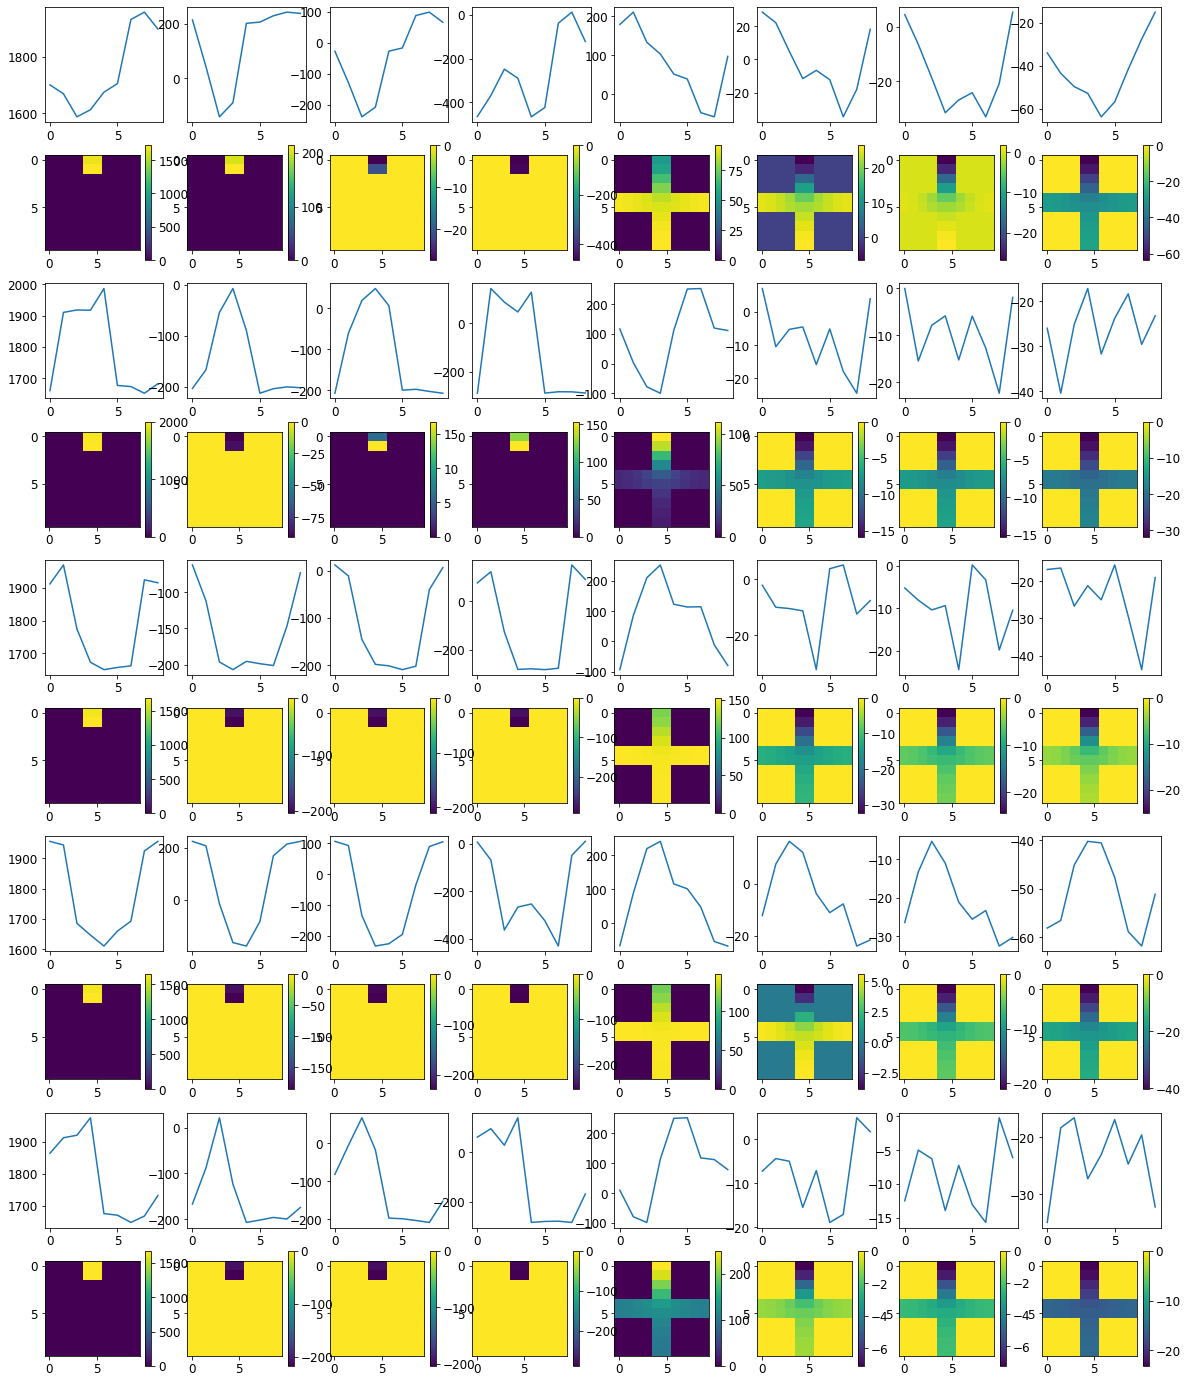

Loss: 


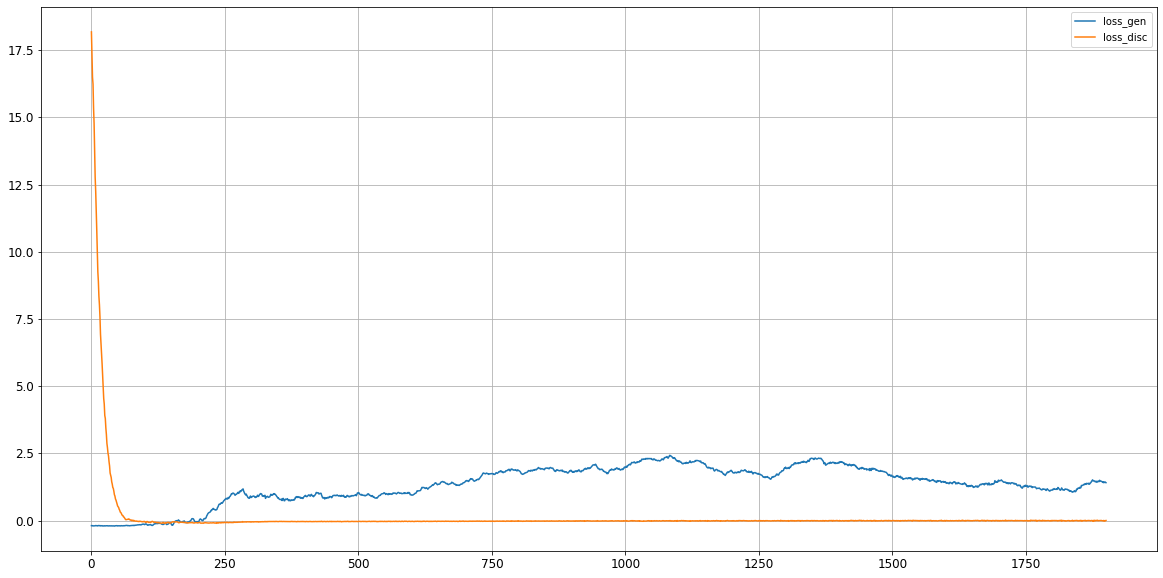

Epoch 2001/10000
critic: 0.001092 - generator: 1.426527 - 2s
disc_numpy 0.050554875
gen_numpy 1.4552964
Epoch 2002/10000
critic: -0.007159 - generator: 1.419679 - 2s
disc_numpy 0.053638857
gen_numpy 1.395479
Epoch 2003/10000
critic: -0.015064 - generator: 1.380110 - 2s
disc_numpy 0.0821867
gen_numpy 1.3516743
Epoch 2004/10000
critic: -0.002013 - generator: 1.397955 - 2s
disc_numpy 0.024198774
gen_numpy 1.4429806
Epoch 2005/10000
critic: -0.001027 - generator: 1.419066 - 2s
disc_numpy 0.08439049
gen_numpy 1.4215745
Epoch 2006/10000
critic: 0.015011 - generator: 1.413215 - 2s
disc_numpy 0.009598557
gen_numpy 1.3860542
Epoch 2007/10000
critic: 0.003666 - generator: 1.427942 - 2s
disc_numpy 0.035089247
gen_numpy 1.3968817
Epoch 2008/10000
critic: -0.002900 - generator: 1.432228 - 2s
disc_numpy -0.03102009
gen_numpy 1.3939592
Epoch 2009/10000
critic: -0.003996 - generator: 1.397884 - 2s
disc_numpy 0.04546685
gen_numpy 1.4076638
Epoch 2010/10000
critic: -0.003891 - generator: 1.400096 - 2s
d

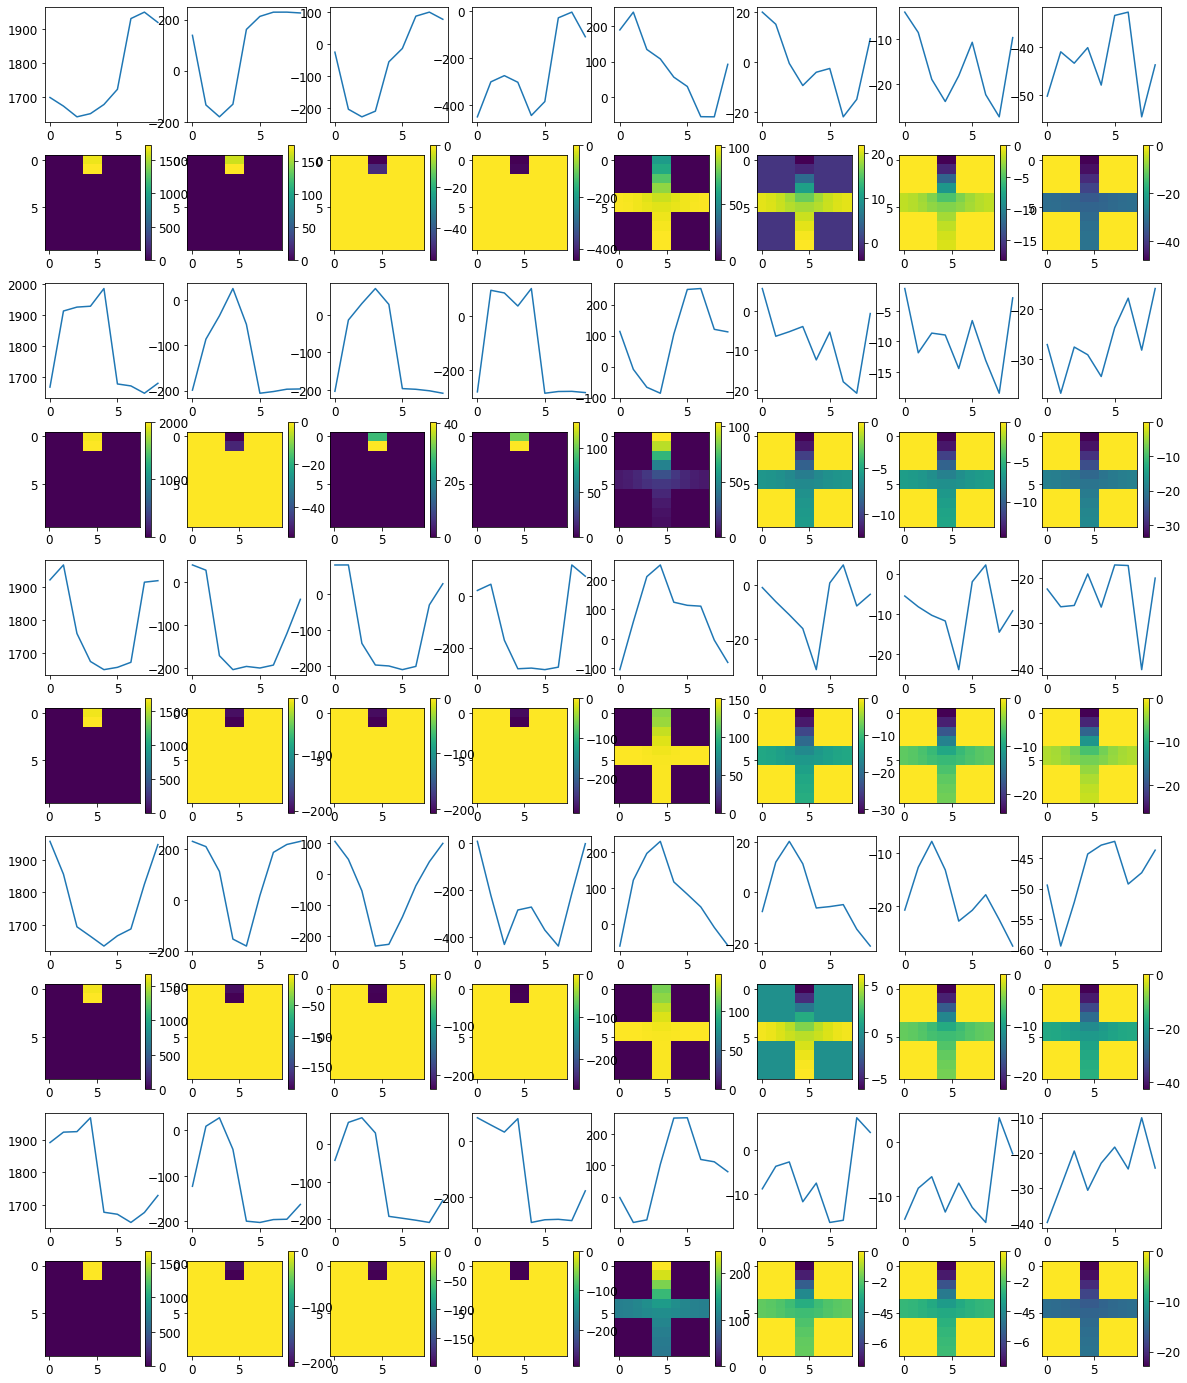

Loss: 


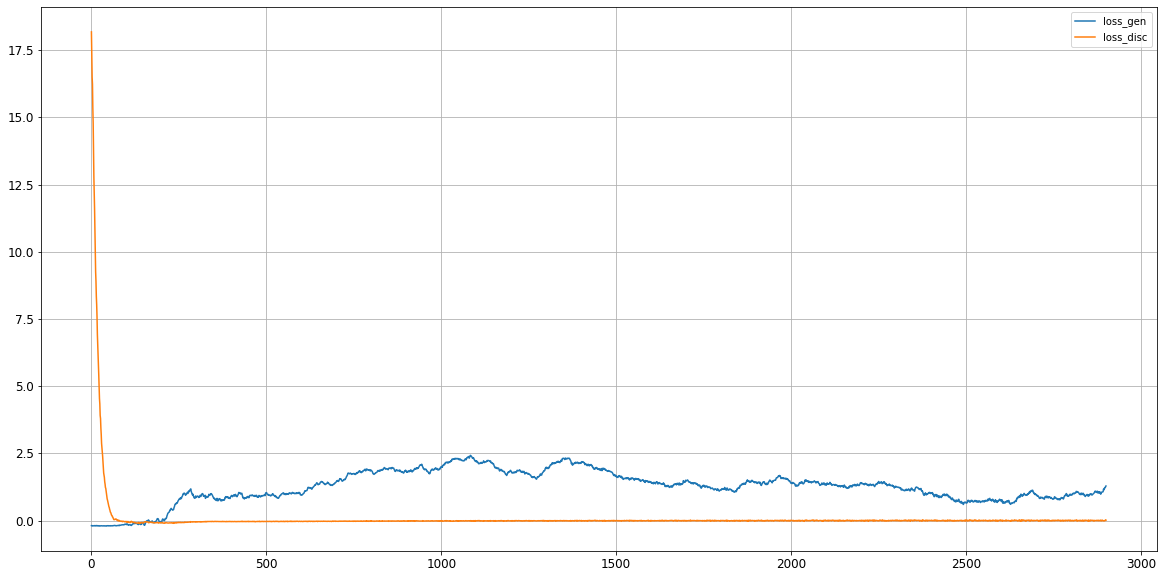

Epoch 3001/10000
critic: -0.003495 - generator: 1.291695 - 2s
disc_numpy 0.034935415
gen_numpy 1.2440069
Epoch 3002/10000
critic: 0.003751 - generator: 1.271027 - 2s
disc_numpy 0.021520838
gen_numpy 1.3110135
Epoch 3003/10000
critic: -0.001773 - generator: 1.327122 - 2s
disc_numpy 0.019134752
gen_numpy 1.3423654
Epoch 3004/10000
critic: -0.012364 - generator: 1.327960 - 2s
disc_numpy 0.023587845
gen_numpy 1.3108027
Epoch 3005/10000
critic: -0.017033 - generator: 1.304972 - 2s
disc_numpy 0.047047537
gen_numpy 1.3225483
Epoch 3006/10000
critic: 0.020682 - generator: 1.282255 - 2s
disc_numpy 0.10773865
gen_numpy 1.3169377
Epoch 3007/10000
critic: 0.000099 - generator: 1.290847 - 2s
disc_numpy -0.044435233
gen_numpy 1.3187594
Epoch 3008/10000
critic: -0.000669 - generator: 1.287038 - 2s
disc_numpy 0.005498521
gen_numpy 1.2306567
Epoch 3009/10000
critic: -0.013372 - generator: 1.330118 - 2s
disc_numpy 0.07776677
gen_numpy 1.325177
Epoch 3010/10000
critic: -0.009187 - generator: 1.338427 - 2

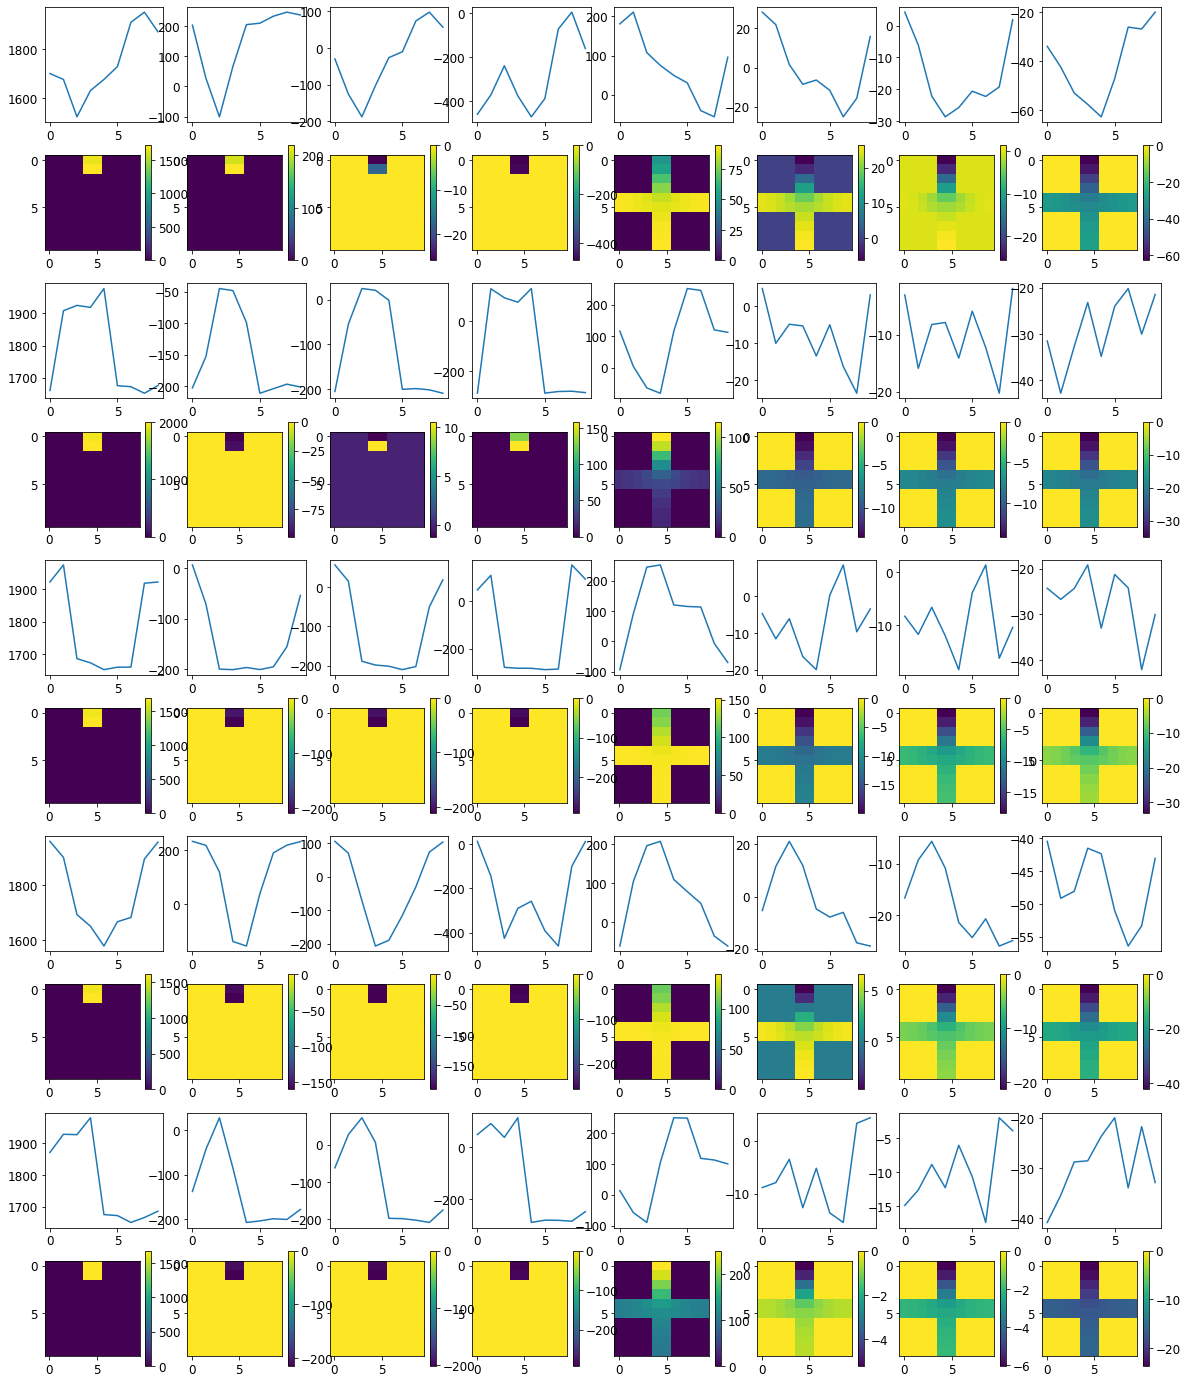

Loss: 


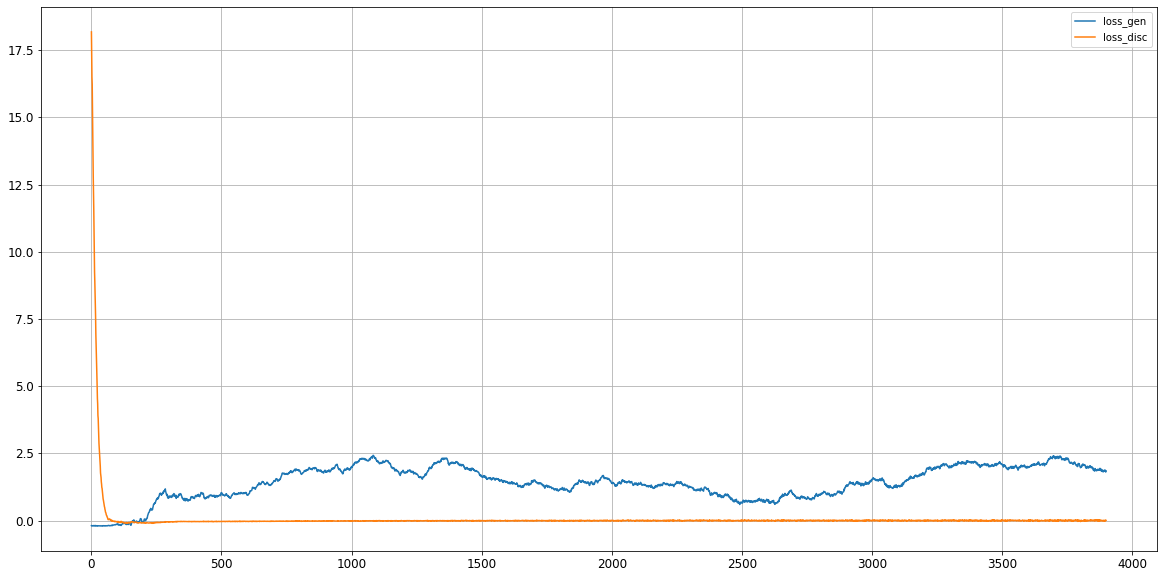

Epoch 4001/10000
critic: 0.004010 - generator: 1.874433 - 2s
disc_numpy 0.026426475
gen_numpy 1.8823899
Epoch 4002/10000
critic: -0.020857 - generator: 1.822870 - 2s
disc_numpy 0.014605075
gen_numpy 1.7933153
Epoch 4003/10000
critic: -0.014254 - generator: 1.782155 - 2s
disc_numpy 0.06481959
gen_numpy 1.7887495
Epoch 4004/10000
critic: -0.023289 - generator: 1.794766 - 2s
disc_numpy 0.02509626
gen_numpy 1.8233395
Epoch 4005/10000
critic: 0.024690 - generator: 1.829948 - 2s
disc_numpy 0.077862844
gen_numpy 1.8397245
Epoch 4006/10000
critic: -0.001690 - generator: 1.835525 - 2s
disc_numpy 0.059330404
gen_numpy 1.7913603
Epoch 4007/10000
critic: 0.000075 - generator: 1.840806 - 2s
disc_numpy 0.015649091
gen_numpy 1.7691482
Epoch 4008/10000
critic: 0.006257 - generator: 1.845607 - 2s
disc_numpy 0.02973215
gen_numpy 1.8766078
Epoch 4009/10000
critic: -0.022131 - generator: 1.813441 - 2s
disc_numpy -0.041295692
gen_numpy 1.8283182
Epoch 4010/10000
critic: 0.001497 - generator: 1.795131 - 2s


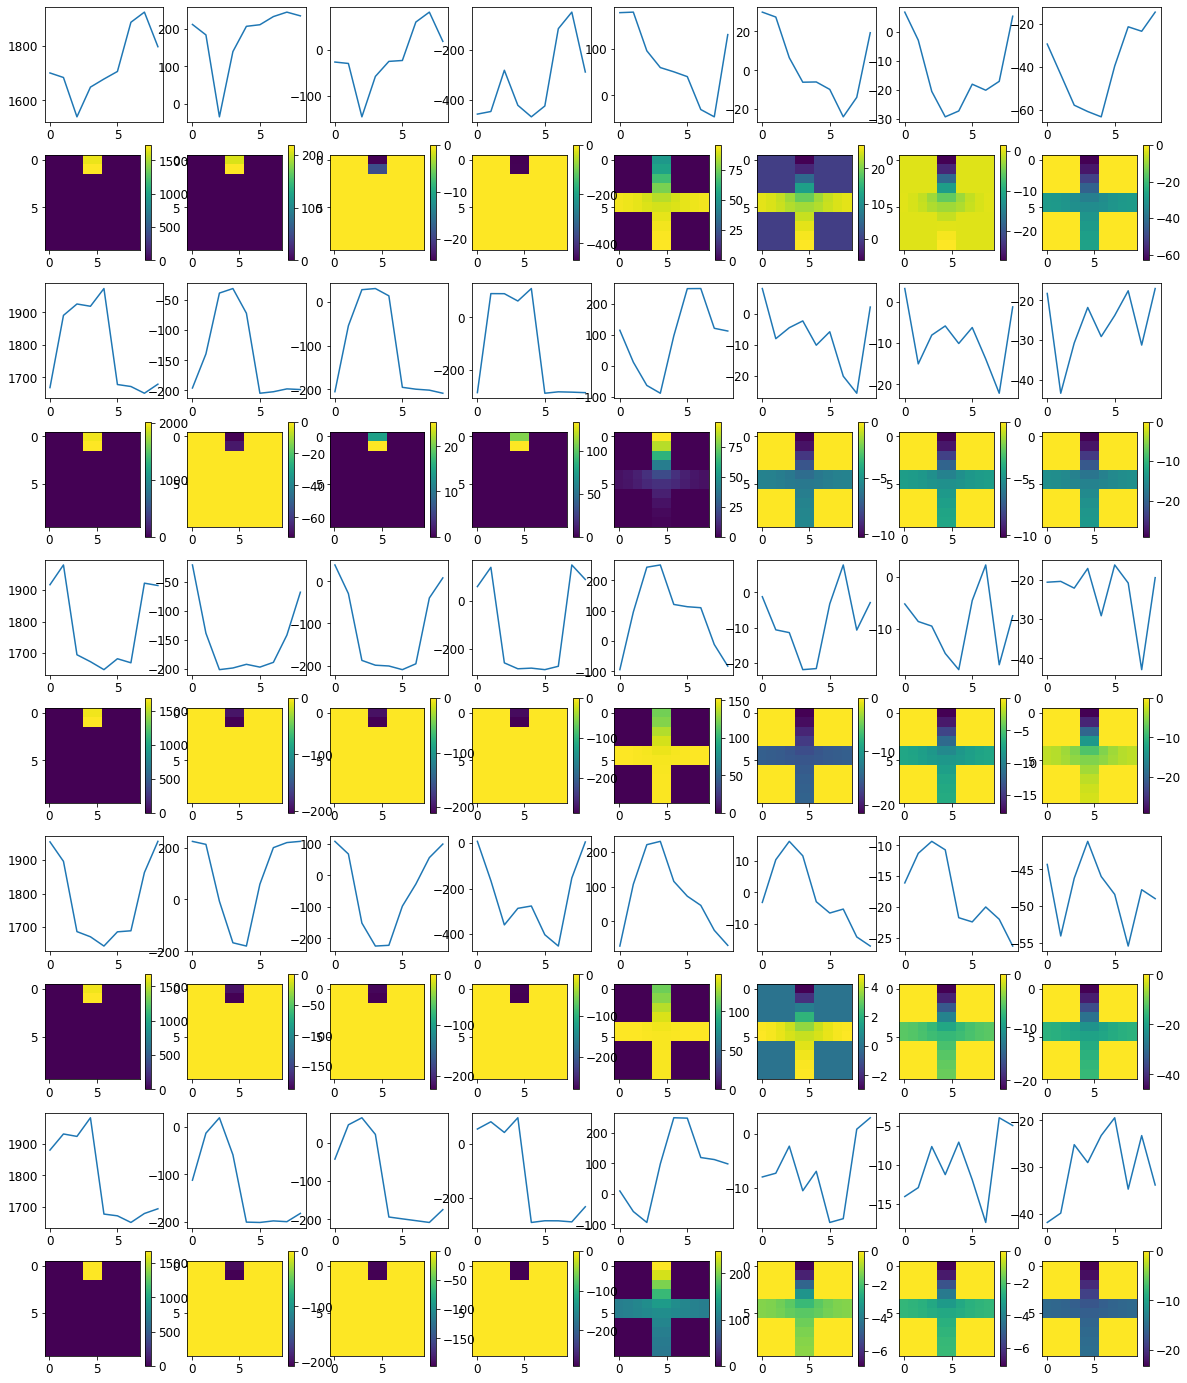

Loss: 


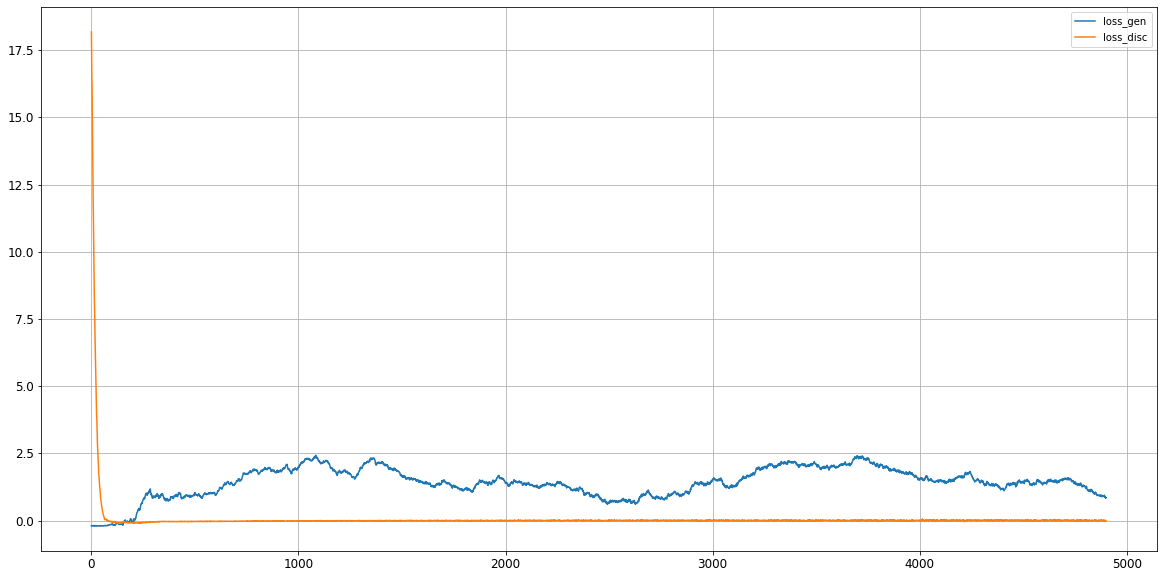

Epoch 5001/10000
critic: -0.005568 - generator: 0.903418 - 2s
disc_numpy 0.09918275
gen_numpy 0.8538045
Epoch 5002/10000
critic: 0.008069 - generator: 0.897007 - 2s
disc_numpy 0.03338169
gen_numpy 0.8912809
Epoch 5003/10000
critic: 0.019372 - generator: 0.844174 - 2s
disc_numpy 0.031901702
gen_numpy 0.8528602
Epoch 5004/10000
critic: 0.008008 - generator: 0.869623 - 2s
disc_numpy 0.051713727
gen_numpy 0.9502963
Epoch 5005/10000
critic: 0.003465 - generator: 0.838158 - 2s
disc_numpy -0.011182491
gen_numpy 0.88247776
Epoch 5006/10000
critic: -0.007079 - generator: 0.863869 - 2s
disc_numpy 0.07997668
gen_numpy 0.835857
Epoch 5007/10000
critic: 0.004505 - generator: 0.835575 - 2s
disc_numpy 0.048125558
gen_numpy 0.76011074
Epoch 5008/10000
critic: -0.009947 - generator: 0.853578 - 2s
disc_numpy 0.004138902
gen_numpy 0.87300766
Epoch 5009/10000
critic: 0.017381 - generator: 0.858038 - 2s
disc_numpy 0.101079755
gen_numpy 0.8048121
Epoch 5010/10000
critic: -0.014835 - generator: 0.846368 - 2s

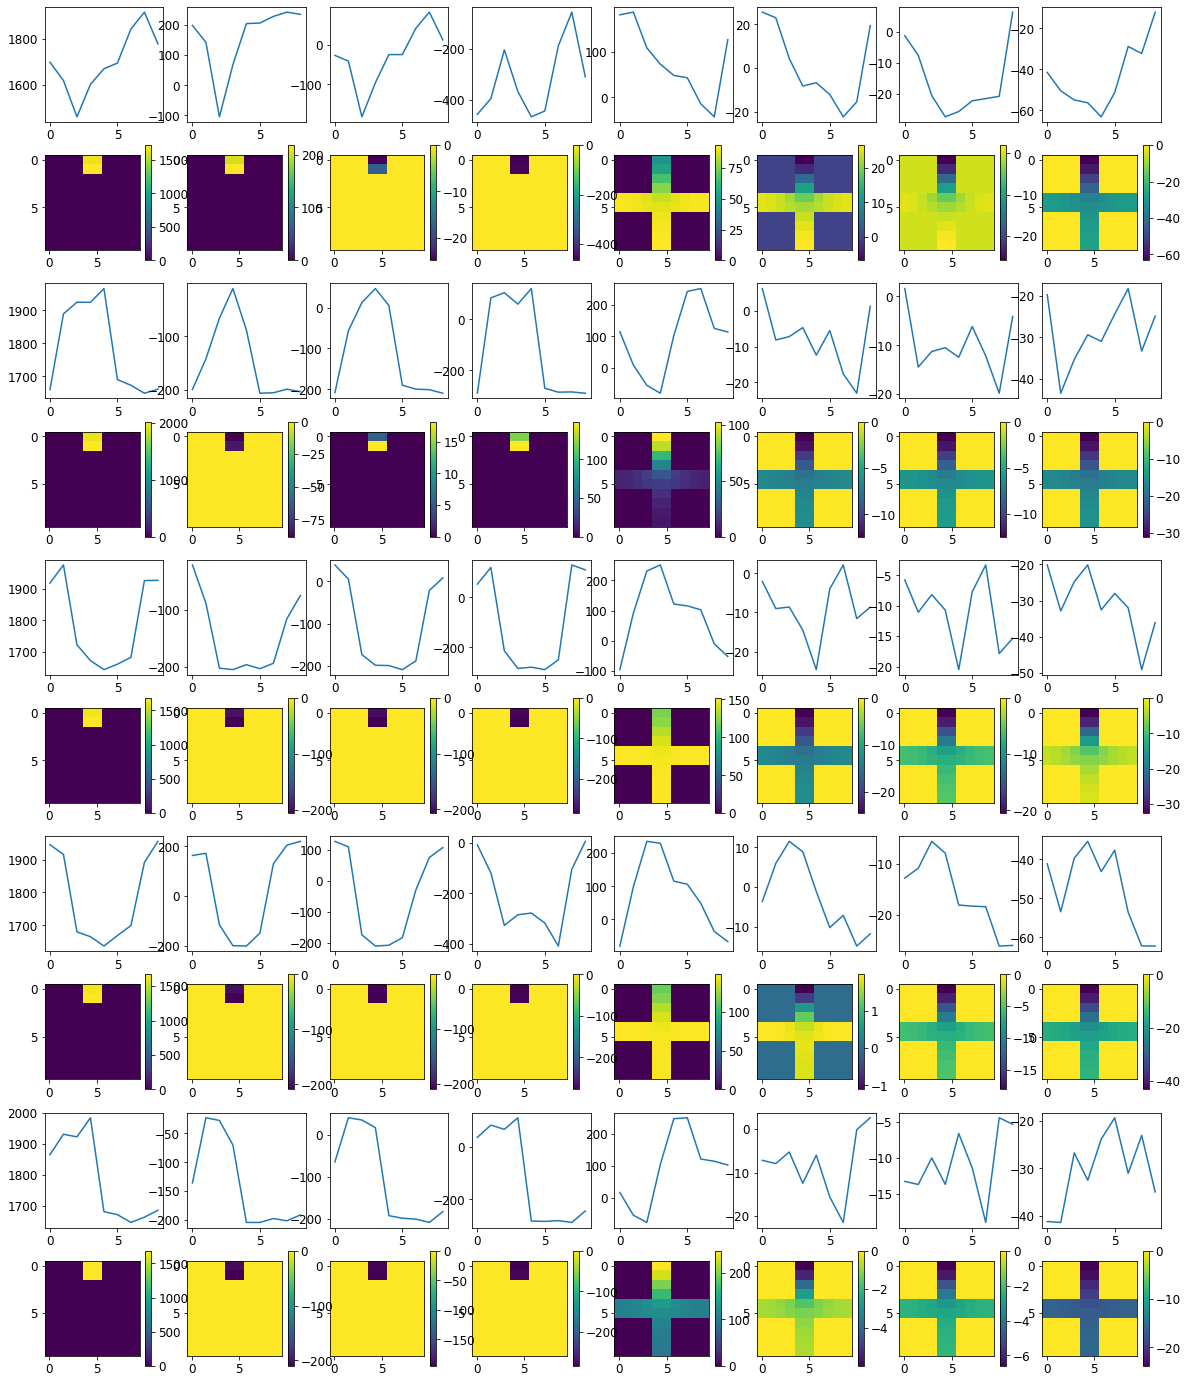

Loss: 


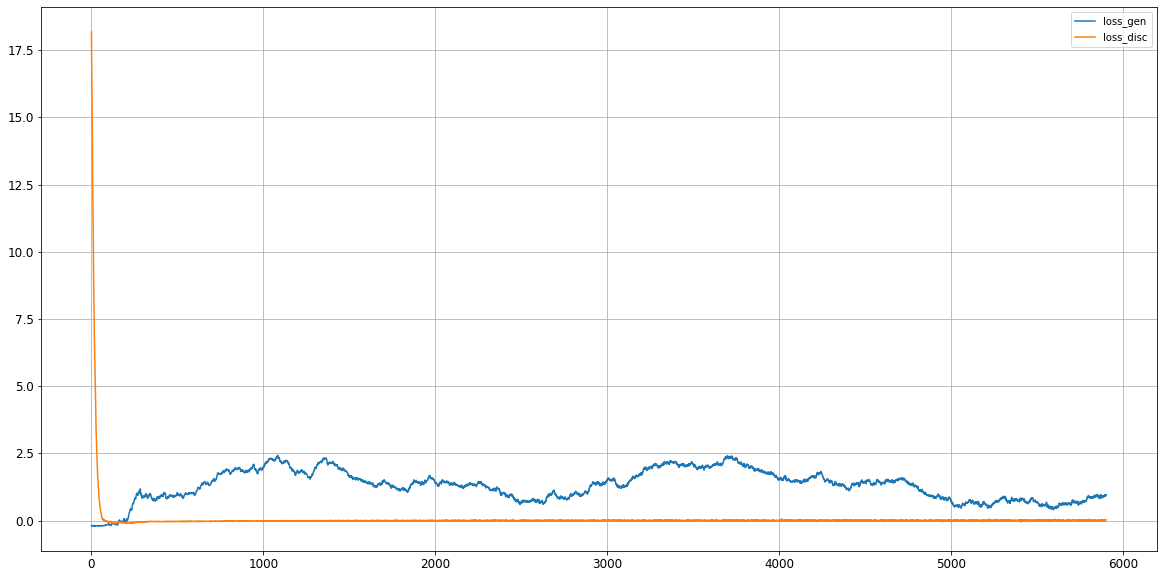

Epoch 6001/10000
critic: -0.009382 - generator: 0.912890 - 2s
disc_numpy 0.013857234
gen_numpy 0.9377189
Epoch 6002/10000
critic: -0.027798 - generator: 0.877451 - 2s
disc_numpy -0.043124475
gen_numpy 1.0033578
Epoch 6003/10000
critic: -0.016307 - generator: 0.926076 - 2s
disc_numpy 0.1258948
gen_numpy 0.9682702
Epoch 6004/10000
critic: -0.024431 - generator: 0.977486 - 2s
disc_numpy -0.09429547
gen_numpy 1.0058494
Epoch 6005/10000
critic: -0.011272 - generator: 1.037961 - 2s
disc_numpy 0.13594283
gen_numpy 1.0775276
Epoch 6006/10000
critic: 0.038977 - generator: 1.032603 - 2s
disc_numpy 0.1255776
gen_numpy 1.0559059
Epoch 6007/10000
critic: 0.023396 - generator: 0.992883 - 2s
disc_numpy -0.014850453
gen_numpy 0.9925563
Epoch 6008/10000
critic: 0.004823 - generator: 1.004373 - 2s
disc_numpy 0.094810426
gen_numpy 0.9832123
Epoch 6009/10000
critic: -0.003632 - generator: 1.012313 - 2s
disc_numpy 0.06520759
gen_numpy 0.91714364
Epoch 6010/10000
critic: 0.015422 - generator: 1.054811 - 2s


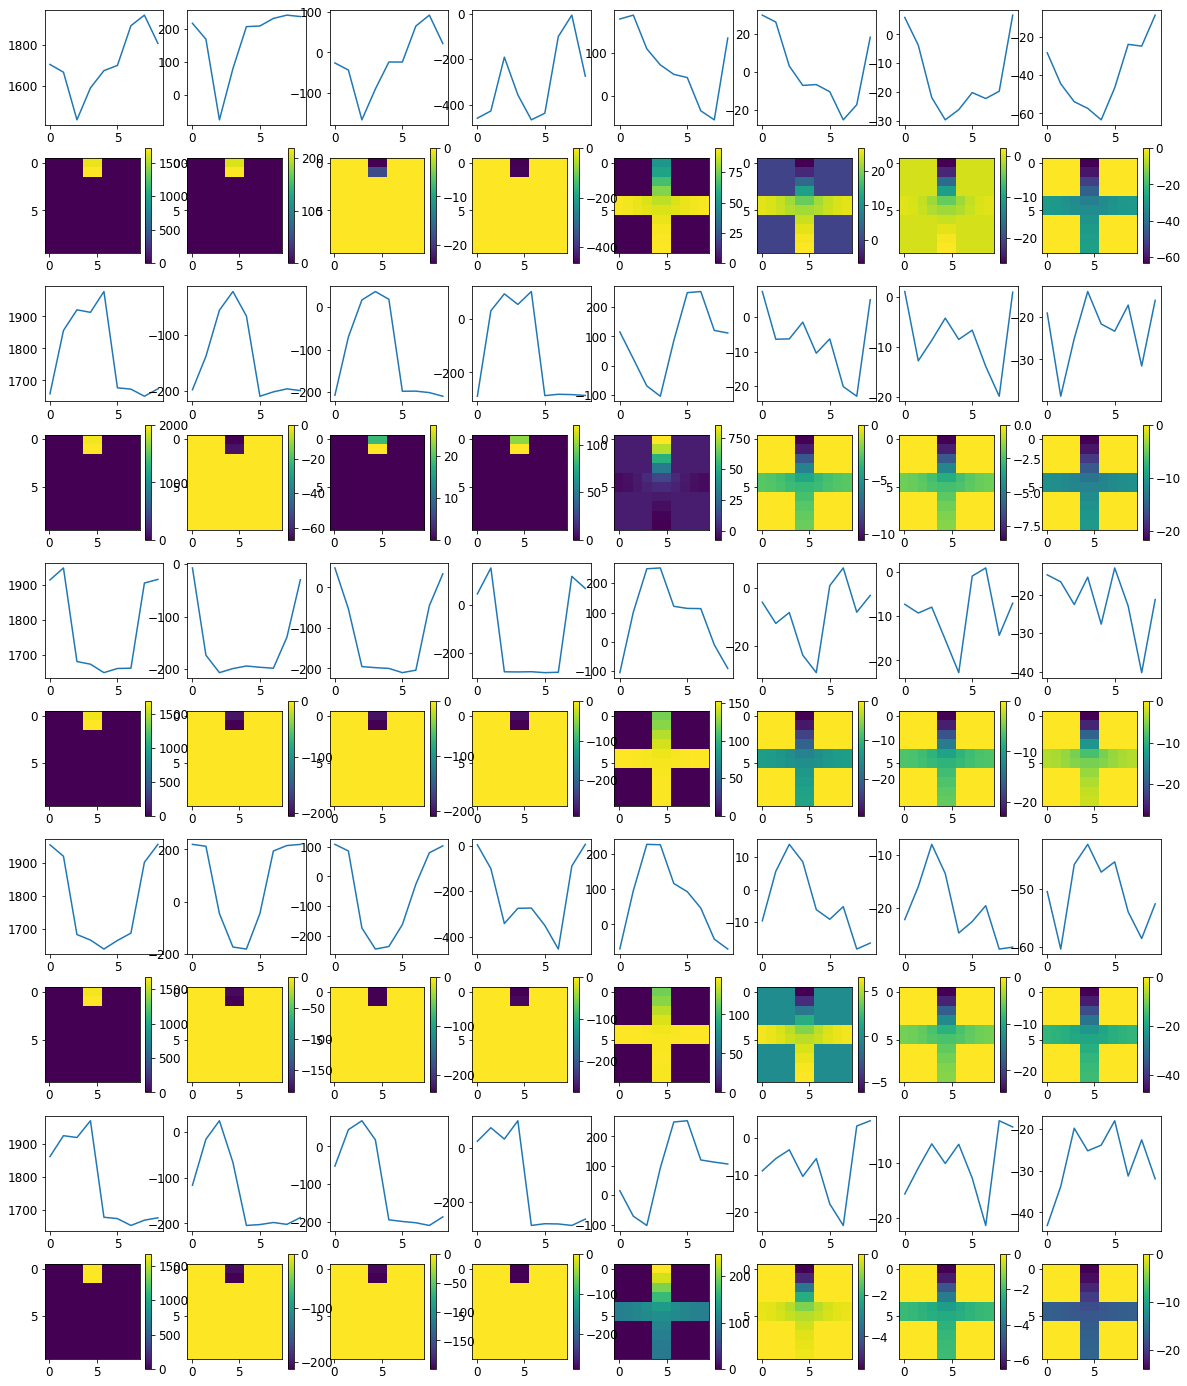

Loss: 


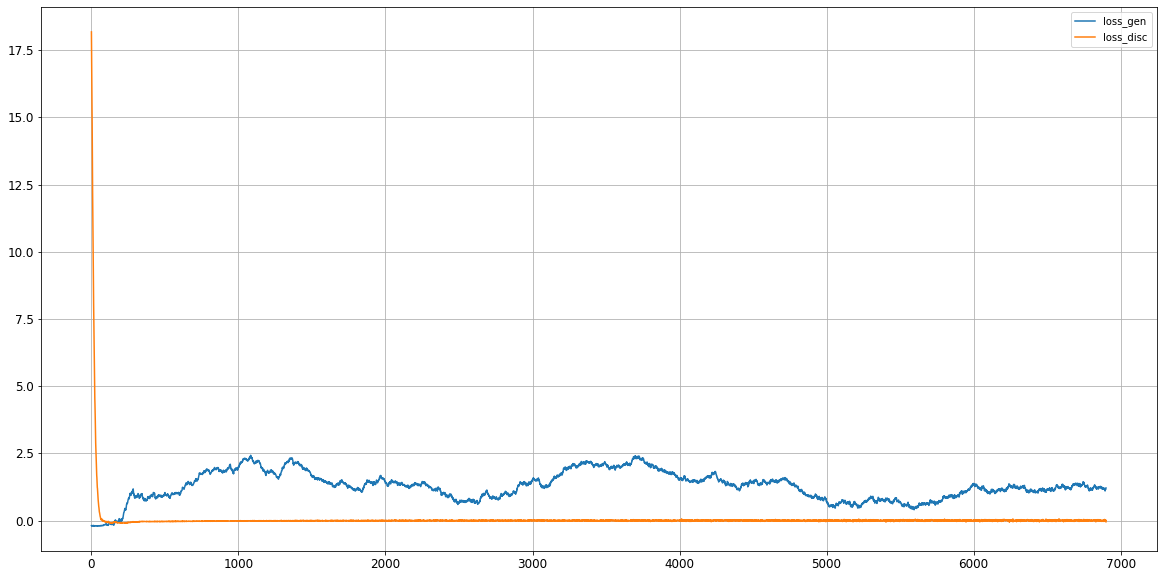

Epoch 7001/10000
critic: -0.002548 - generator: 1.201434 - 2s
disc_numpy 0.014085431
gen_numpy 1.0937148
Epoch 7002/10000
critic: 0.015766 - generator: 1.204300 - 2s
disc_numpy 0.031749804
gen_numpy 1.2466336
Epoch 7003/10000
critic: 0.034210 - generator: 1.221992 - 2s
disc_numpy 0.08702174
gen_numpy 1.2394618
Epoch 7004/10000
critic: 0.014672 - generator: 1.217547 - 3s
disc_numpy -0.00026350096
gen_numpy 1.2408613
Epoch 7005/10000
critic: 0.003938 - generator: 1.233417 - 2s
disc_numpy 0.15664154
gen_numpy 1.2660536
Epoch 7006/10000
critic: 0.005484 - generator: 1.301723 - 2s
disc_numpy -0.03516581
gen_numpy 1.3380431
Epoch 7007/10000
critic: -0.026405 - generator: 1.332752 - 2s
disc_numpy -0.09628434
gen_numpy 1.333954
Epoch 7008/10000
critic: 0.008425 - generator: 1.334161 - 2s
disc_numpy 0.038040727
gen_numpy 1.3010267
Epoch 7009/10000
critic: 0.013309 - generator: 1.360294 - 2s
disc_numpy -0.02738218
gen_numpy 1.4017241
Epoch 7010/10000
critic: -0.010593 - generator: 1.321896 - 2s


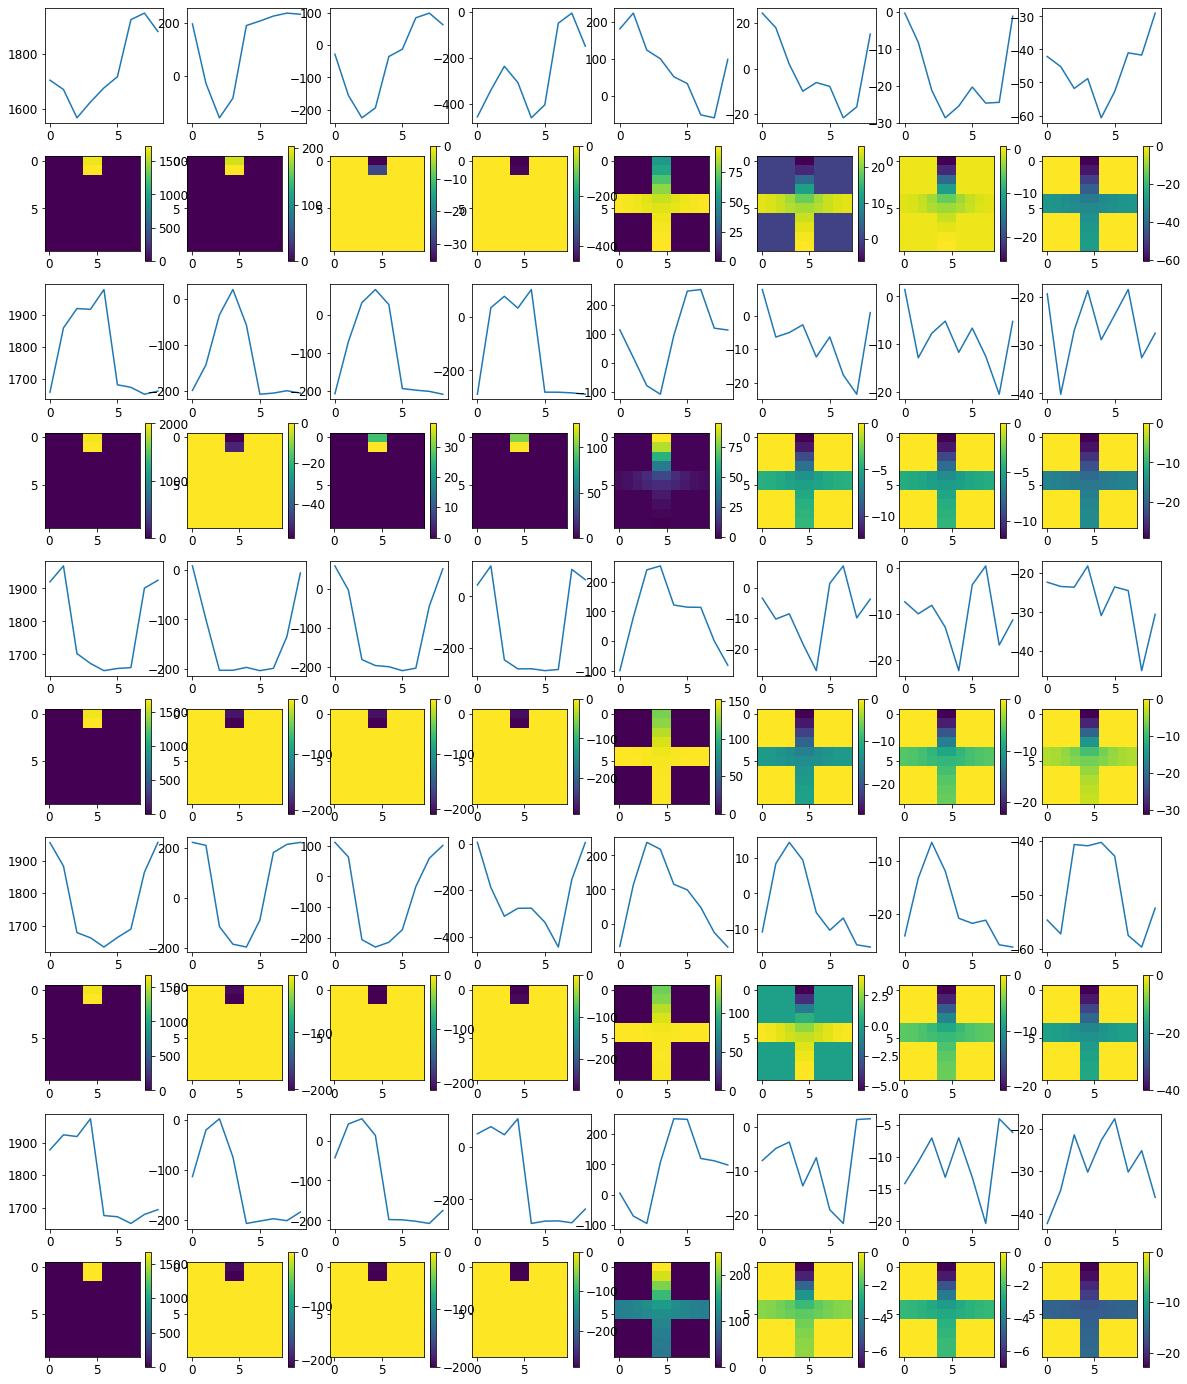

Loss: 


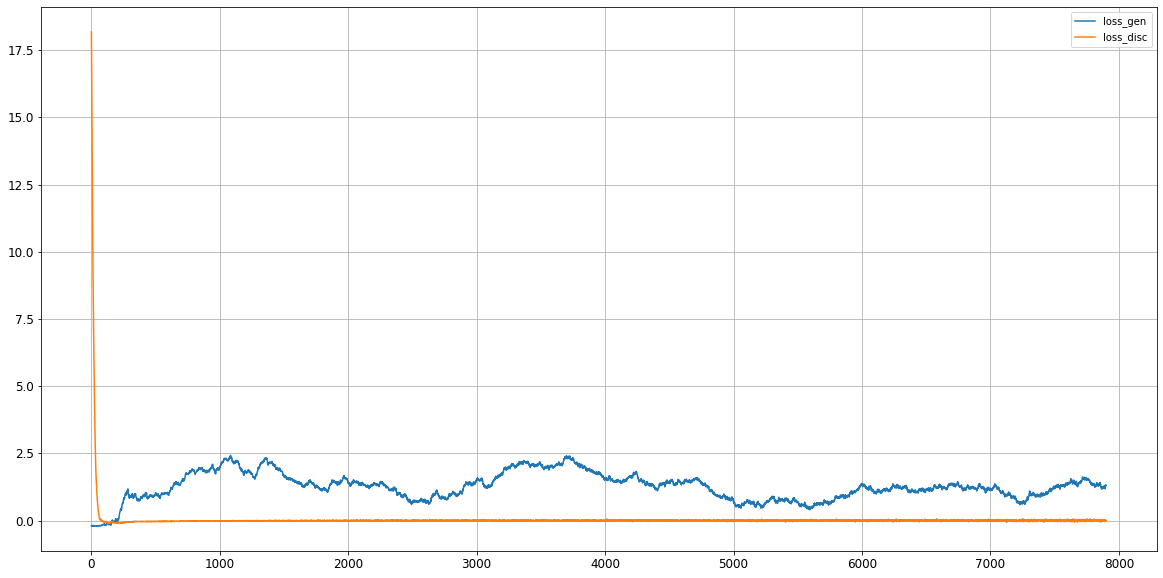

Epoch 8001/10000
critic: -0.003439 - generator: 1.301956 - 2s
disc_numpy -0.041561544
gen_numpy 1.2974882
Epoch 8002/10000
critic: -0.007624 - generator: 1.336361 - 2s
disc_numpy -0.14873995
gen_numpy 1.3405894
Epoch 8003/10000
critic: -0.019794 - generator: 1.359433 - 2s
disc_numpy 0.077576056
gen_numpy 1.4321849
Epoch 8004/10000
critic: -0.006703 - generator: 1.407677 - 2s
disc_numpy 0.08452639
gen_numpy 1.3804685
Epoch 8005/10000
critic: -0.028280 - generator: 1.376453 - 2s
disc_numpy 0.11889613
gen_numpy 1.4545293
Epoch 8006/10000
critic: -0.002779 - generator: 1.315463 - 2s
disc_numpy 0.057035208
gen_numpy 1.2861067
Epoch 8007/10000
critic: 0.008682 - generator: 1.326694 - 2s
disc_numpy -0.033473283
gen_numpy 1.3425016
Epoch 8008/10000
critic: 0.010387 - generator: 1.347479 - 3s
disc_numpy -0.014818169
gen_numpy 1.3308152
Epoch 8009/10000
critic: -0.026431 - generator: 1.387840 - 2s
disc_numpy 0.033387873
gen_numpy 1.4657952
Epoch 8010/10000
critic: -0.018087 - generator: 1.409746

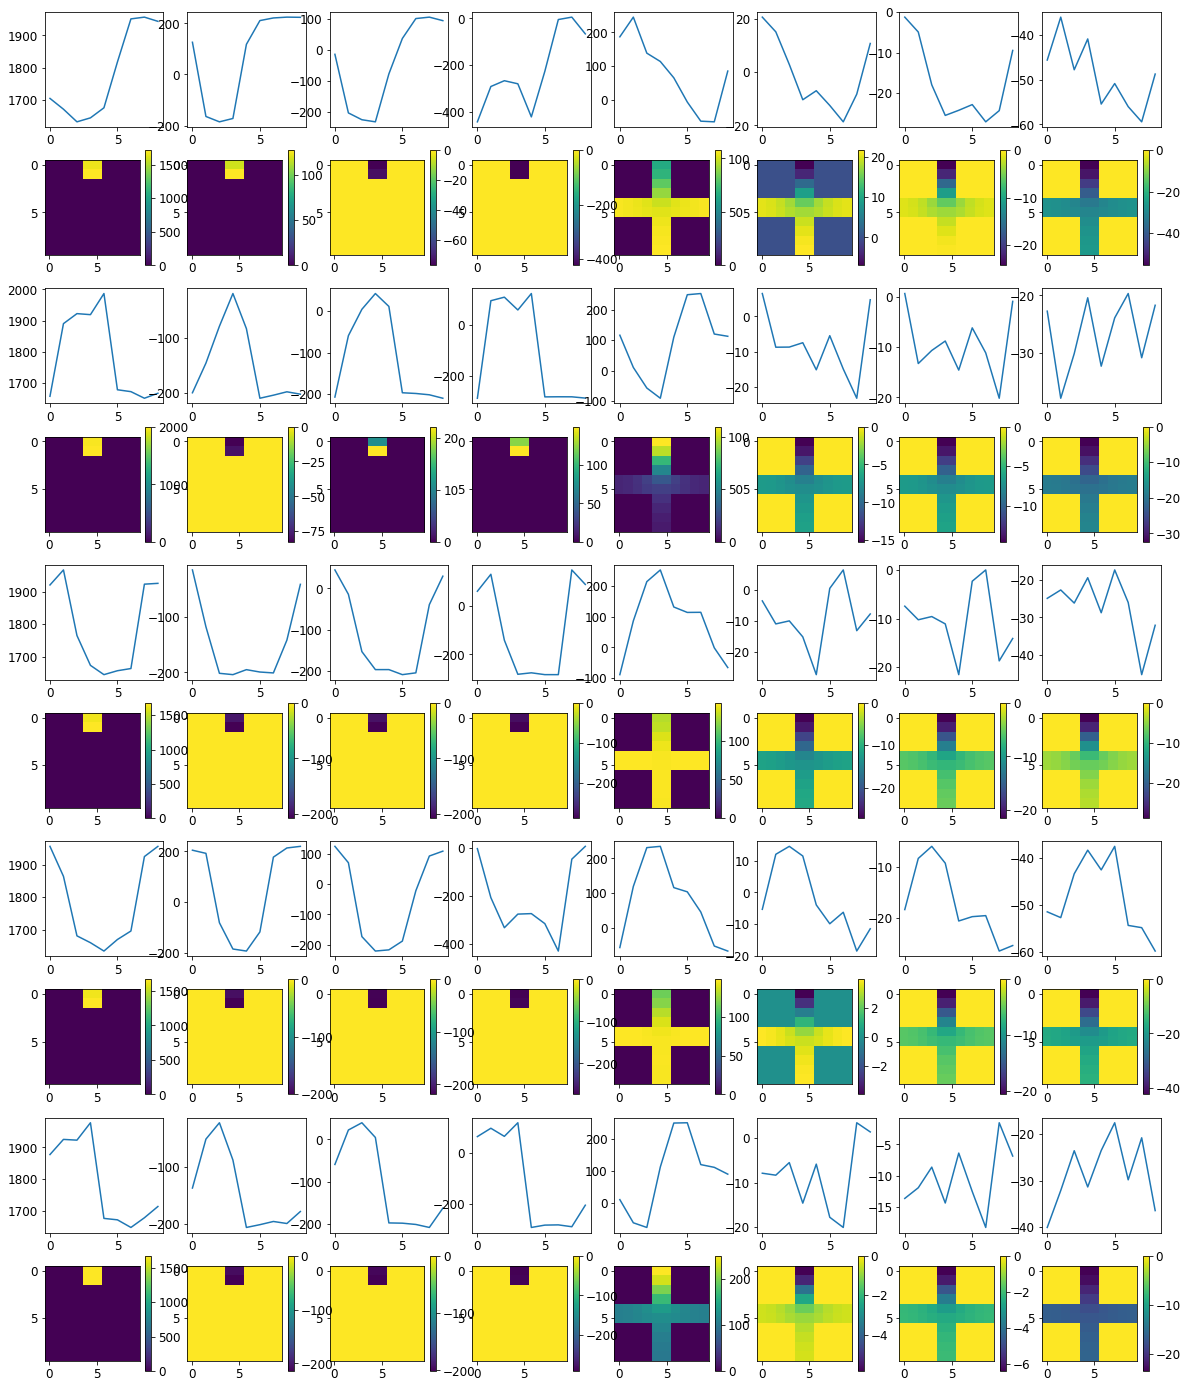

Loss: 


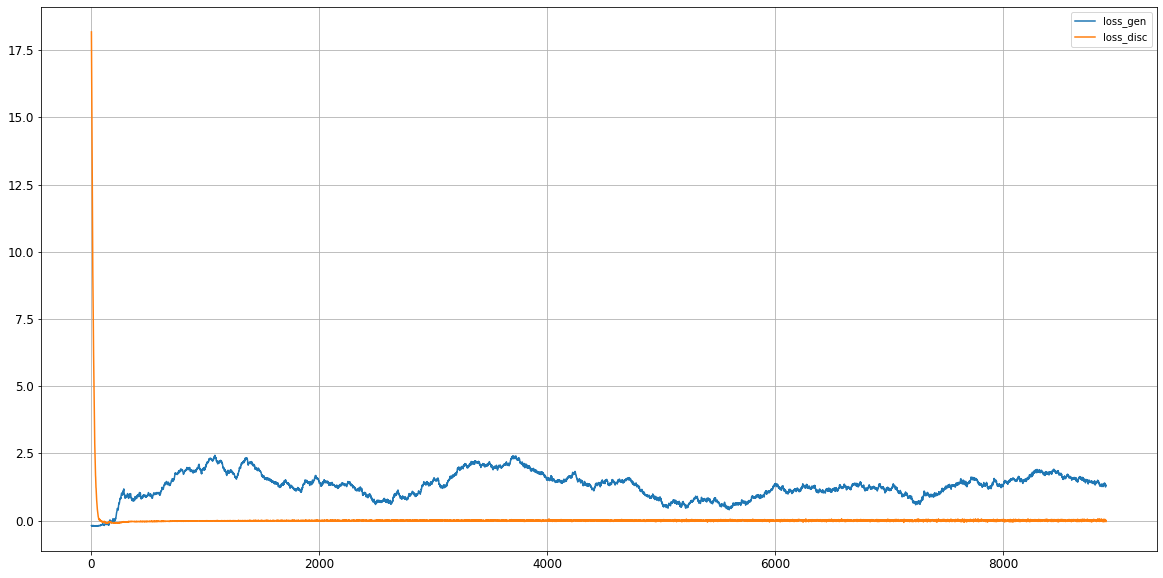

Epoch 9001/10000
critic: 0.023446 - generator: 1.315536 - 2s
disc_numpy 0.03559576
gen_numpy 1.2504164
Epoch 9002/10000
critic: 0.014170 - generator: 1.323869 - 2s
disc_numpy -0.048080303
gen_numpy 1.4038055
Epoch 9003/10000
critic: 0.021728 - generator: 1.308959 - 2s
disc_numpy 0.1464585
gen_numpy 1.2801356
Epoch 9004/10000
critic: 0.007088 - generator: 1.292035 - 2s
disc_numpy 0.04418592
gen_numpy 1.3839964
Epoch 9005/10000
critic: 0.020341 - generator: 1.319431 - 2s
disc_numpy 0.09772946
gen_numpy 1.2120955
Epoch 9006/10000
critic: -0.009845 - generator: 1.324982 - 2s
disc_numpy -0.044330634
gen_numpy 1.2981108
Epoch 9007/10000
critic: 0.021978 - generator: 1.270628 - 2s
disc_numpy 0.072392665
gen_numpy 1.2471234
Epoch 9008/10000
critic: -0.008097 - generator: 1.319256 - 3s
disc_numpy -0.036002293
gen_numpy 1.3154633
Epoch 9009/10000
critic: -0.003864 - generator: 1.268621 - 2s
disc_numpy -0.1108472
gen_numpy 1.2150558
Epoch 9010/10000
critic: 0.004147 - generator: 1.220208 - 2s
dis

In [36]:
hist = train(train_dataset, epochs=10000)

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


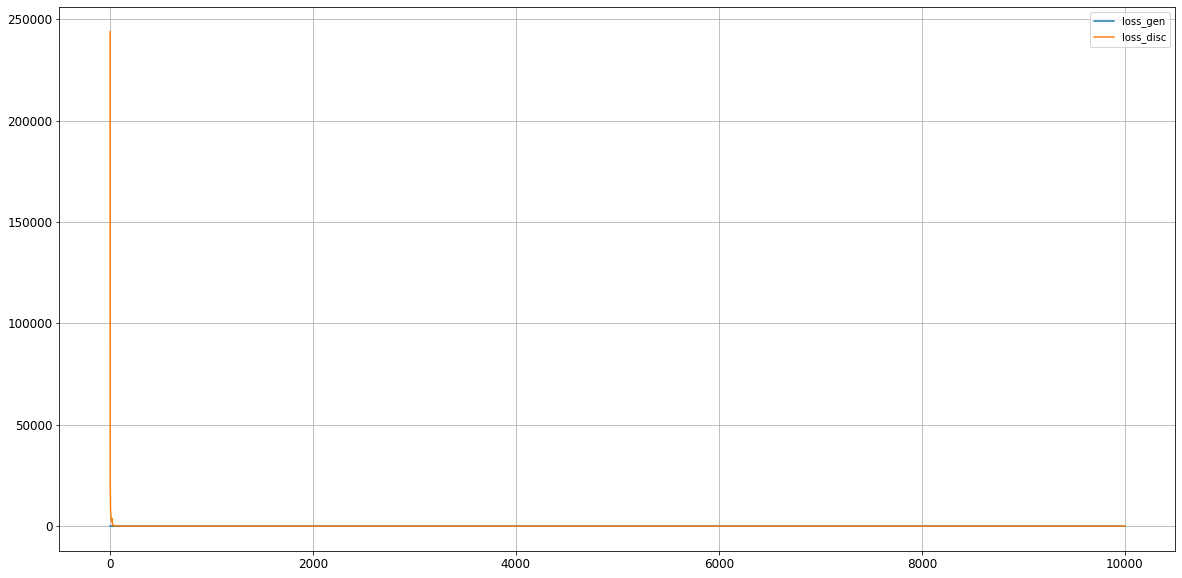

In [38]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(hist)
ax.legend(['loss_gen', 'loss_disc'])
#ax.set_yscale('log')
ax.grid()

In [40]:
#from tensorflow.keras.models import load_model
import joblib
joblib.dump(scaler, "scaler-tfex.pkl")
wgan.save("wgan-tfex.h5")

In [ ]:
np.random.seed(10)
tf.random.set_seed(10)

noise = tf.random.normal(shape=[1, latent_space])
X_generated = scaler.inverse_transform((gan.layers[0].predict(noise).reshape(ntimes,15)+1)/2)
X_generated = pca_compress.inverse_transform(X_generated)
X_generated[X_generated<0.0] = 0.0

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:,i*nl*nc+4], '-o')
    ax.flatten()[i].set_title(group)

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train_1D[2930:3020,i*nl*nc+4])
    ax.flatten()[i].set_title(group)

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_generated.reshape(ntimes,len(groups),nl,nc)[0,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_train_1D.reshape(len(times),len(groups),nl,nc)[2932,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

In [ ]:
npredict = 5
noise = tf.random.normal(shape=[npredict, latent_space])
X_generated = scaler.inverse_transform((gan.layers[0].predict(noise).reshape(npredict*ntimes,15)+1)/2)
X_generated = pca_compress.inverse_transform(X_generated)
X_generated = X_generated.reshape(npredict, ntimes, len(groups)*nl*nc)
fig, ax = plt.subplots(npredict*2,len(groups), figsize=[20,npredict*5])
for j in range(npredict):
    for i, group in enumerate(groups):
        for k in range(0,10,10): 
            ax.flatten()[i+2*j*len(groups)].plot(X_generated[j][:,i*nl*nc+4+10*k], '-')
    for i, group in enumerate(groups):
        im = ax.flatten()[i+(2*j+1)*len(groups)].imshow(X_generated[j].reshape(ntimes,len(groups),nl,nc)[4,i,:,:])
        fig.colorbar(im, ax=ax.flatten()[i+(2*j+1)*len(groups)])
